In [115]:
import pandas as pd
from IPython.display import display
from IPython.display import Image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from boruta import BorutaPy

from scipy import stats as ss

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x :'%5f' %x)

In [2]:
data = pd.read_csv('Data/predictionStoreP03.csv', parse_dates=['date','year_week','competition_since','promo_since'])
data.loc[data.competition_distance == data['competition_distance'].max(), 'competition_distance'] = 100000


In [3]:
num_atributes = data.select_dtypes('int64','float64')

### 2.0 Helper Functions

In [4]:
def cramer_v(x,y):    
    # Criação da tabela de contingência (Confusion Matrix 'cm')
    cm = pd.crosstab(x,y)
    cm = np.asmatrix(cm)

    #Coletando valores de n(soma de todos os valores)
    n = cm.sum()

    # r (linhas) e k(colunas)
    r,k = cm.shape

    #Cálculo de chi2, onde será utilizado apenas o primeiro valor (valor do teste)
    chi2 = ss.chi2_contingency(cm)[0]
    
    #Correções sugeridas para que não haja tendência de alta na fórmula
    chi2corr = max(0 , chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1,rcorr-1) ) )

### 3.0. Filtragem de variáveis

#### 3.1. Filtragem das linhas

In [5]:
df = data.loc[data['open'] != 0 & (data['sales'] > 0)]    

#### 3.0. Filtragem das colunas

In [6]:
df = df.drop(['customers','open','promo_interval', 'month_map'], axis=1)

### 4.0. Análise exploratória dos dados

In [7]:
sns.set(rc={'figure.figsize':(40,10)})

#### 4.1. Análise Univariada

##### 4.1.1 Análise isolda da target

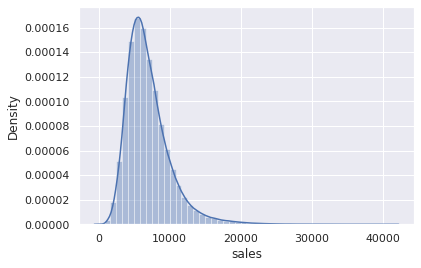

In [8]:
ax = sns.distplot(df.sales)

##### 4.1.2 Análise de variáveis numéricas

In [9]:
num_atrib = df.select_dtypes(['int64','float64'])

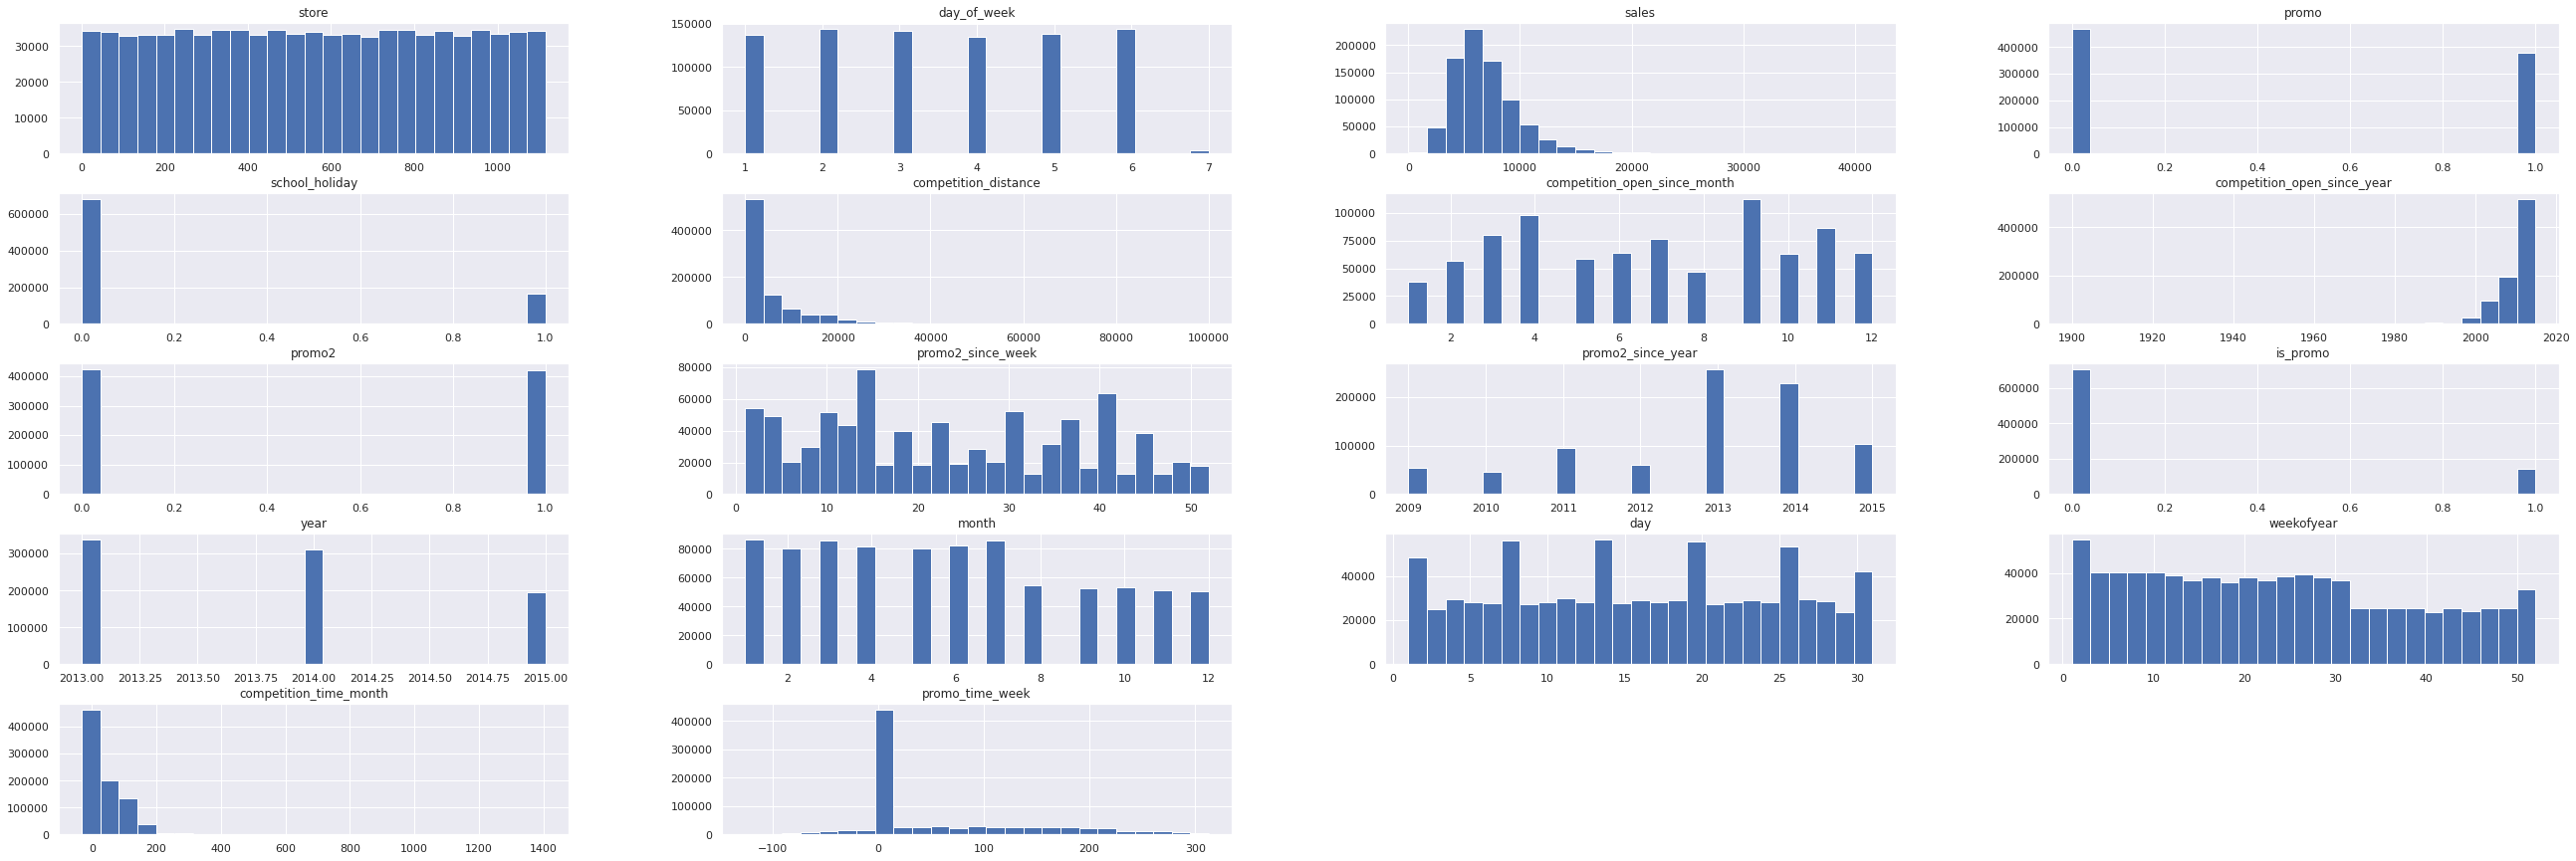

In [10]:
num_atrib.hist(figsize=(45,15), bins=25);

In [11]:
num_atrib = df.select_dtypes(['int64','float64'])

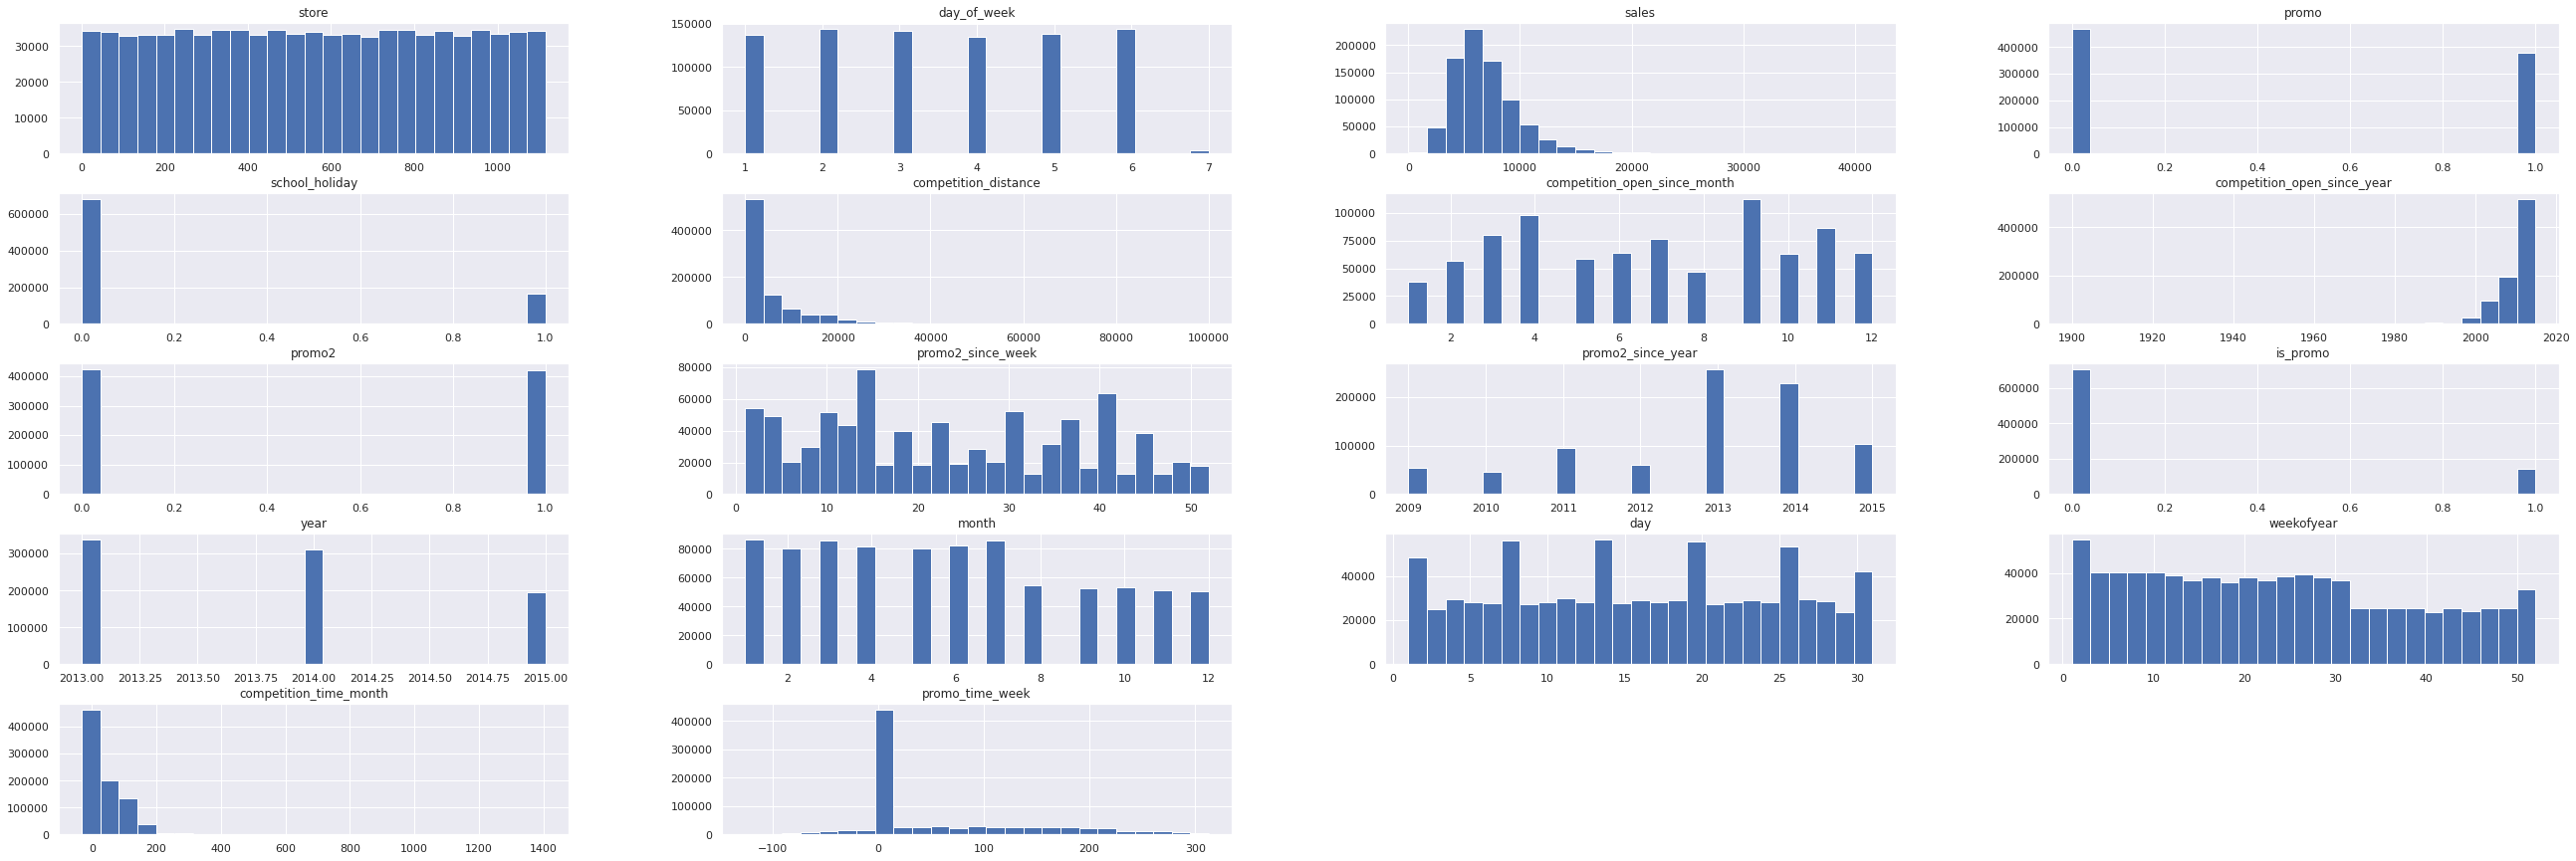

In [12]:
num_atrib.hist(figsize=(45,15), bins=25);

##### 4.1.3 Análise de variáveis categóricas

In [13]:
cat_atrib = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_atrib.assortment.unique()

array(['basic', 'extended', 'extra'], dtype=object)

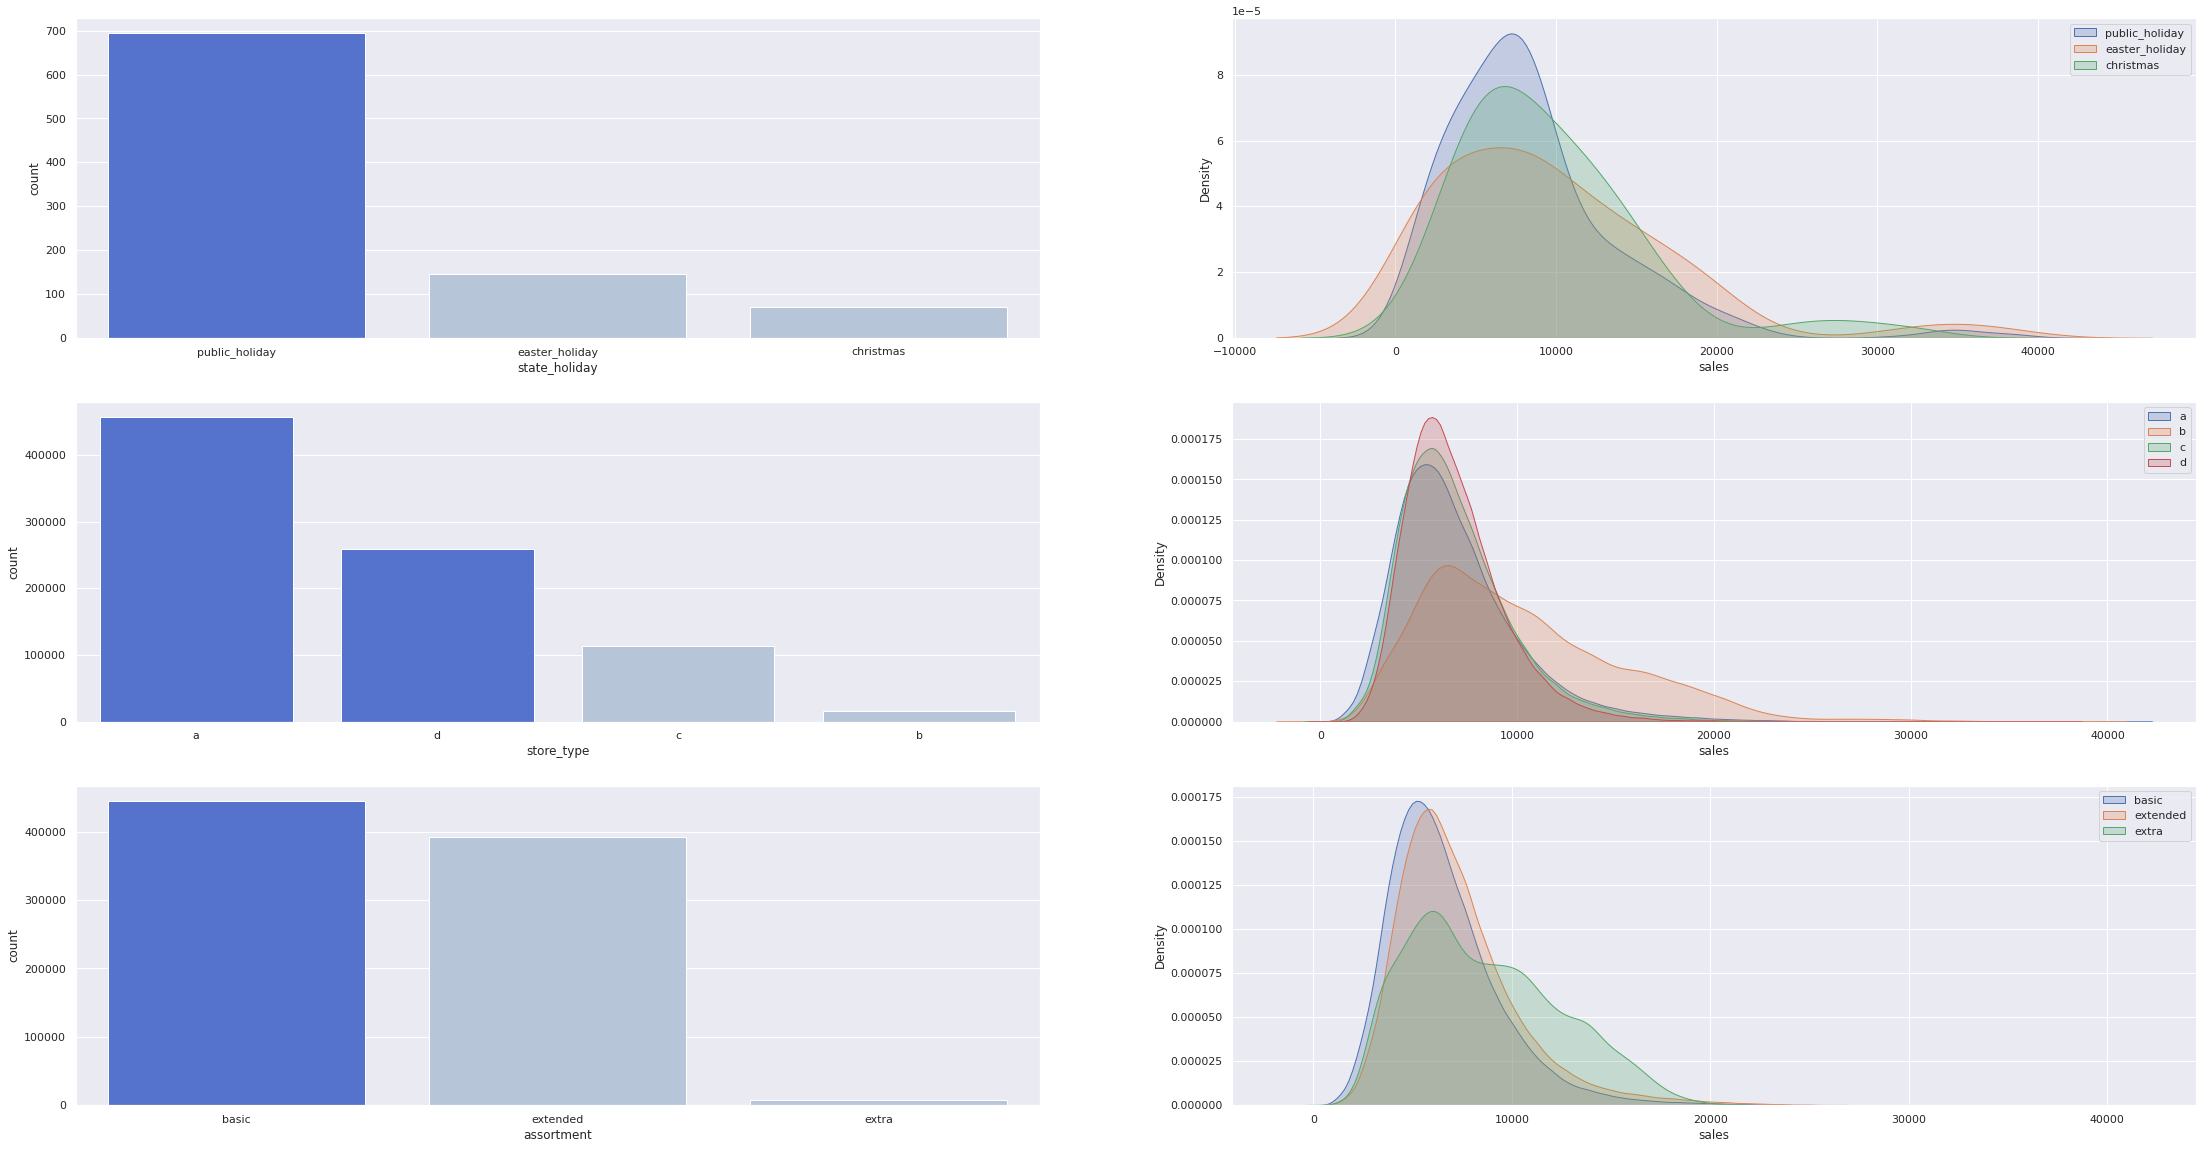

In [14]:
# state_holiday
sns.set(rc = {'figure.figsize' : (38,20)})

plt.subplot(3,2,1)
sns.countplot(cat_atrib.loc[cat_atrib['state_holiday'] != 'regular_day' , 'state_holiday'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,2)
sns.kdeplot(data=df[df['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# story_type
plt.subplot(3,2,3)
sns.countplot(cat_atrib['store_type'], palette= ['royalblue','royalblue','lightsteelblue','lightsteelblue'], order='adcb');

plt.subplot(3,2,4)
sns.kdeplot(data=df[df['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(cat_atrib['assortment'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,6)
sns.kdeplot(data=df[df['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()



#### 4.1. Análise Bivariada

##### 1. Lojas com maior sortimento deveriam vender mais.  

    True

"Hipótese validada. Extra detém   38.29%, o 'extended' e 'baisc' ficam respectivamente com  32.36% e   29.35% do total de vendas"

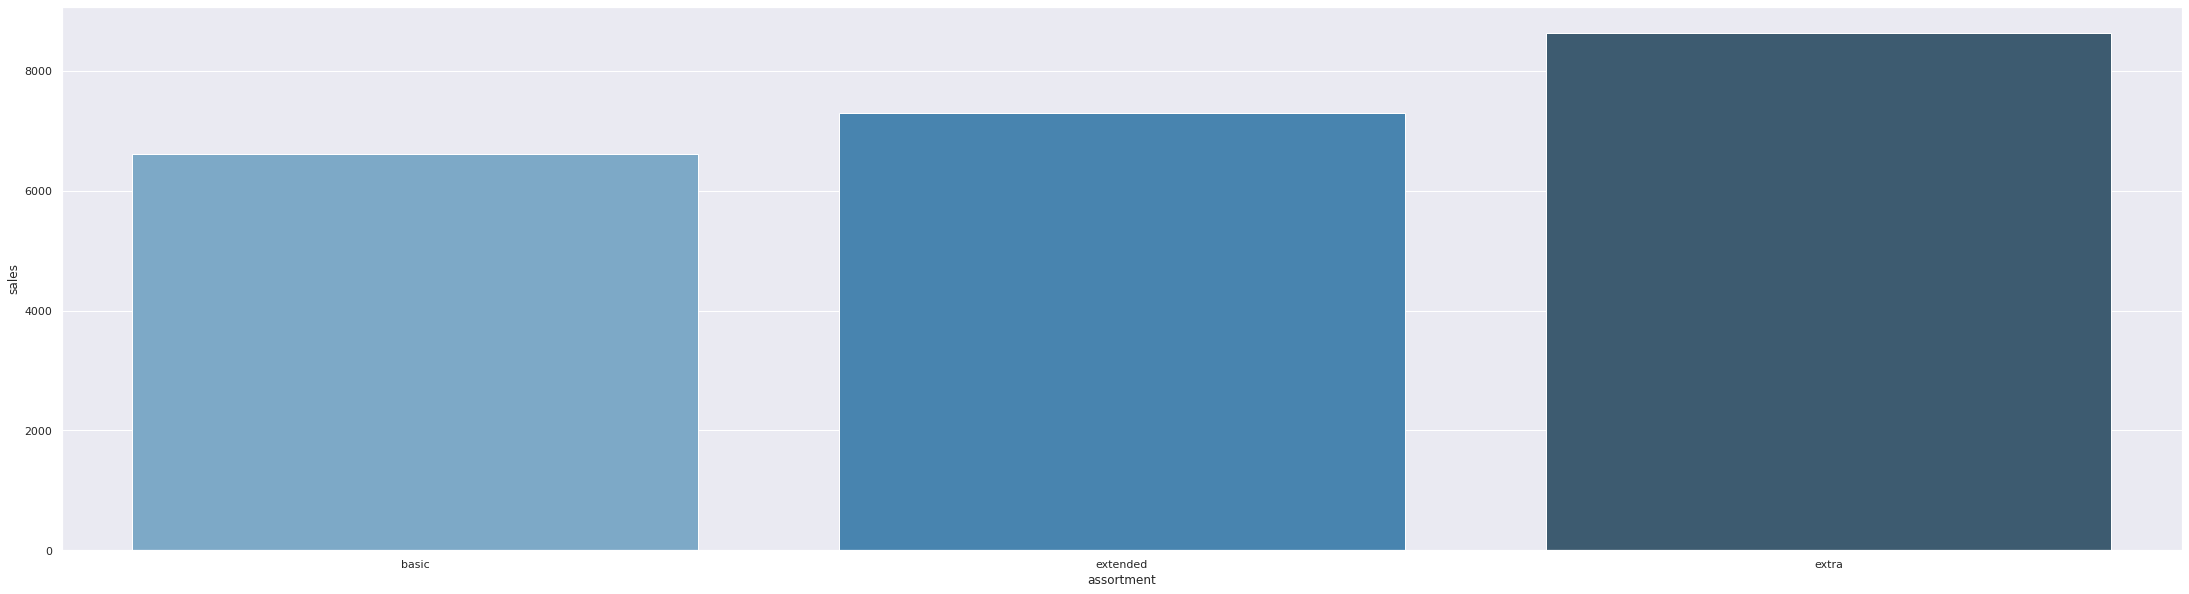

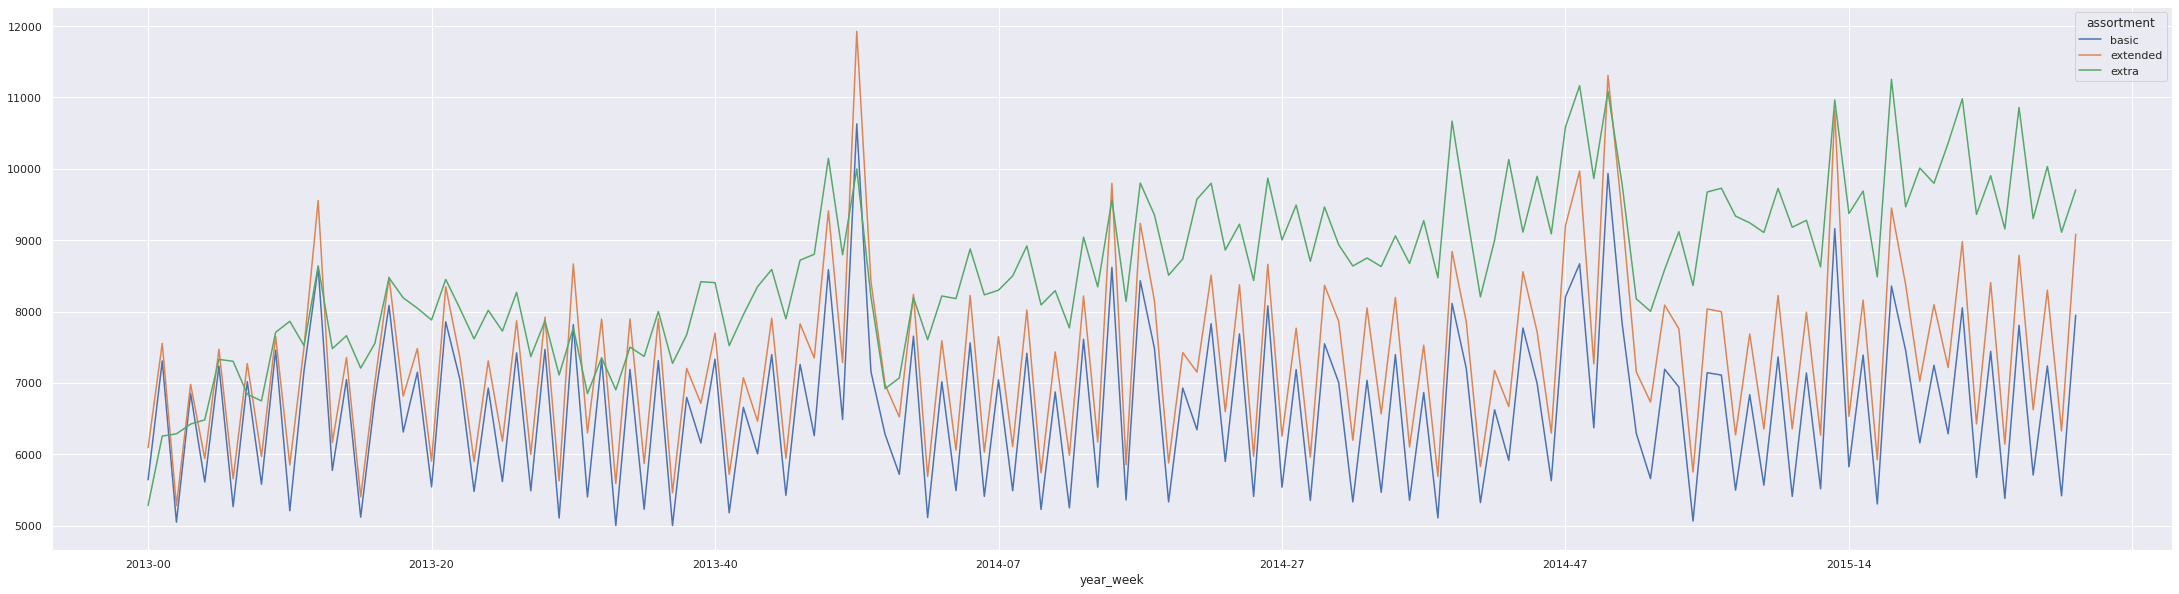

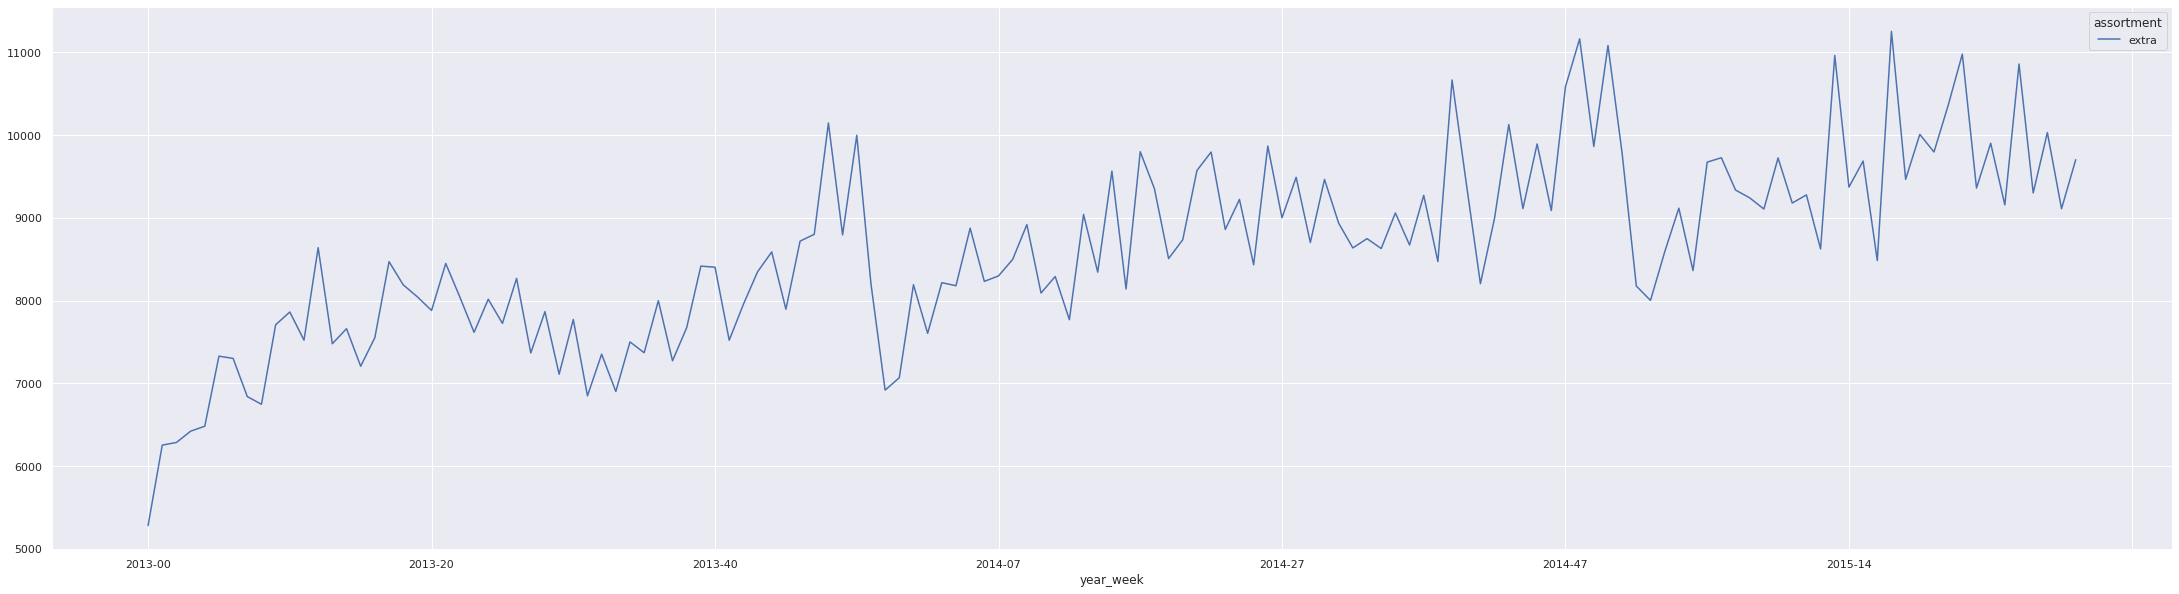

In [15]:
## Variável 01
sns.set(rc={'figure.figsize':(38,10)})
assortment = df[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(data= assortment, x= 'assortment', y= 'sales', palette='Blues_d');

#Variável 02
assort_date = df[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
assort_date.pivot(index='year_week', columns='assortment', values='sales').plot()

#Comportamento isolado do extra
assort_date[assort_date['assortment'] == 'extra'].pivot(index='year_week', columns='assortment', values='sales').plot()



display(f"Hipótese validada. Extra detém  {float((assortment.loc[assortment['assortment'] == 'extra','sales'] ) / assortment['sales'].sum()): .2%}, \
o 'extended' e 'baisc' ficam respectivamente com {float((assortment.loc[assortment['assortment'] == 'extended','sales'] ) / assortment['sales'].sum()): .2%} e \
 {float((assortment.loc[assortment['assortment'] == 'basic','sales'] ) / assortment['sales'].sum()): .2%} do total de vendas")

##### 2. Lojas com competidores mais próximos deveriam vender menos.

    False.
    Não demonstra comportamento claro de ligação direta de distância com vendas. Variando bastante no decorrer da série.

In [16]:
#df.loc[df.competition_distance == df['competition_distance'].max(), 'competition_distance'] = 20000


In [17]:
comp_dist_sales = df[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,20000,1000))
comp_dist_sales['comp_dist_bined'] = pd.cut(comp_dist_sales['competition_distance'], bins=bins)


<AxesSubplot:>

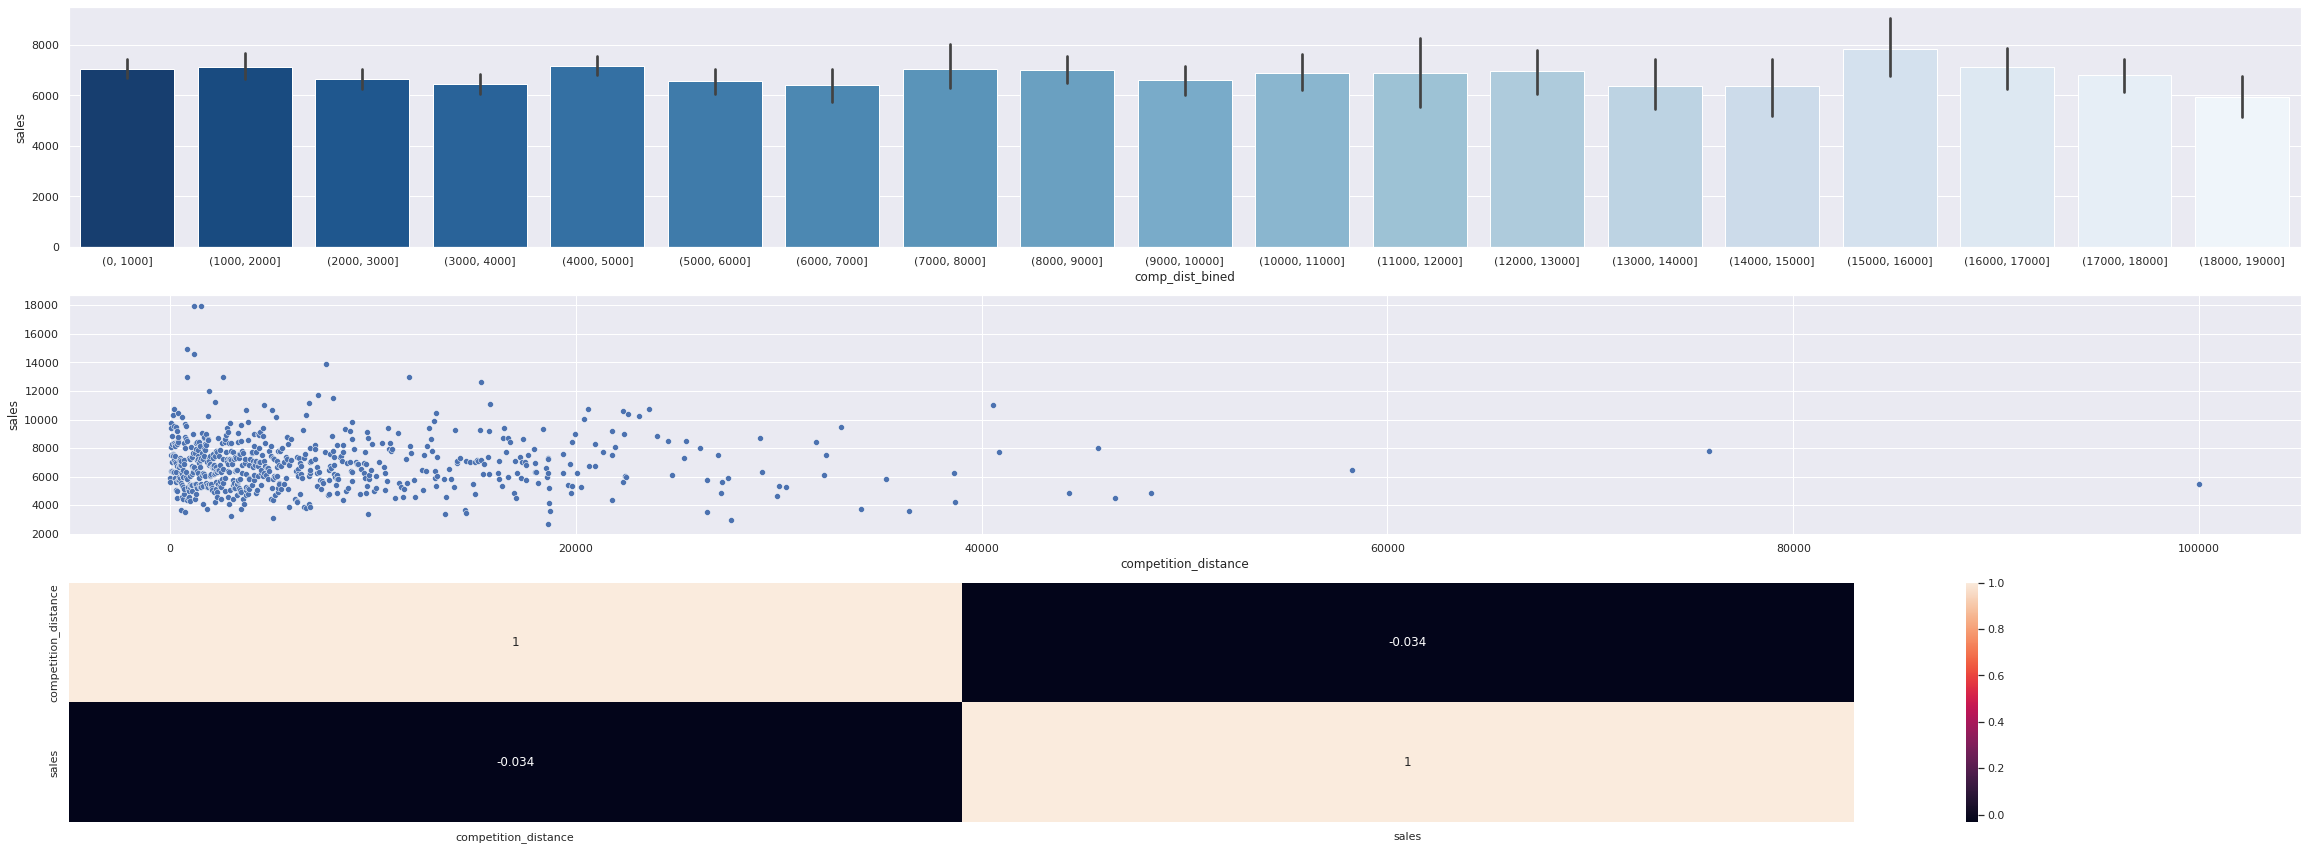

In [18]:
sns.set(rc={'figure.figsize':(40,15)})
plt.subplot(3,1,1)
sns.barplot(data= comp_dist_sales, x='comp_dist_bined', y='sales', palette='Blues_r');

plt.subplot(3,1,2)
sns.scatterplot(data=comp_dist_sales, x='competition_distance', y='sales' );

plt.subplot(3,1,3)
sns.heatmap(comp_dist_sales.corr(method='pearson'), annot=True)


##### 3. Lojas com competidores a mais tempo deveriam vender menos.    

    True. 
    Apesar de ser uma queda muito pequena nas vendas, há uma tendência de ascendente no número de vendas no decorrer do tempo.

In [19]:
comp_osm = df[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
comp_osm1 = comp_osm[(comp_osm['competition_time_month']<120) & (comp_osm['competition_time_month'] !=0)]

In [20]:
df.competition_time_month.min()

-32

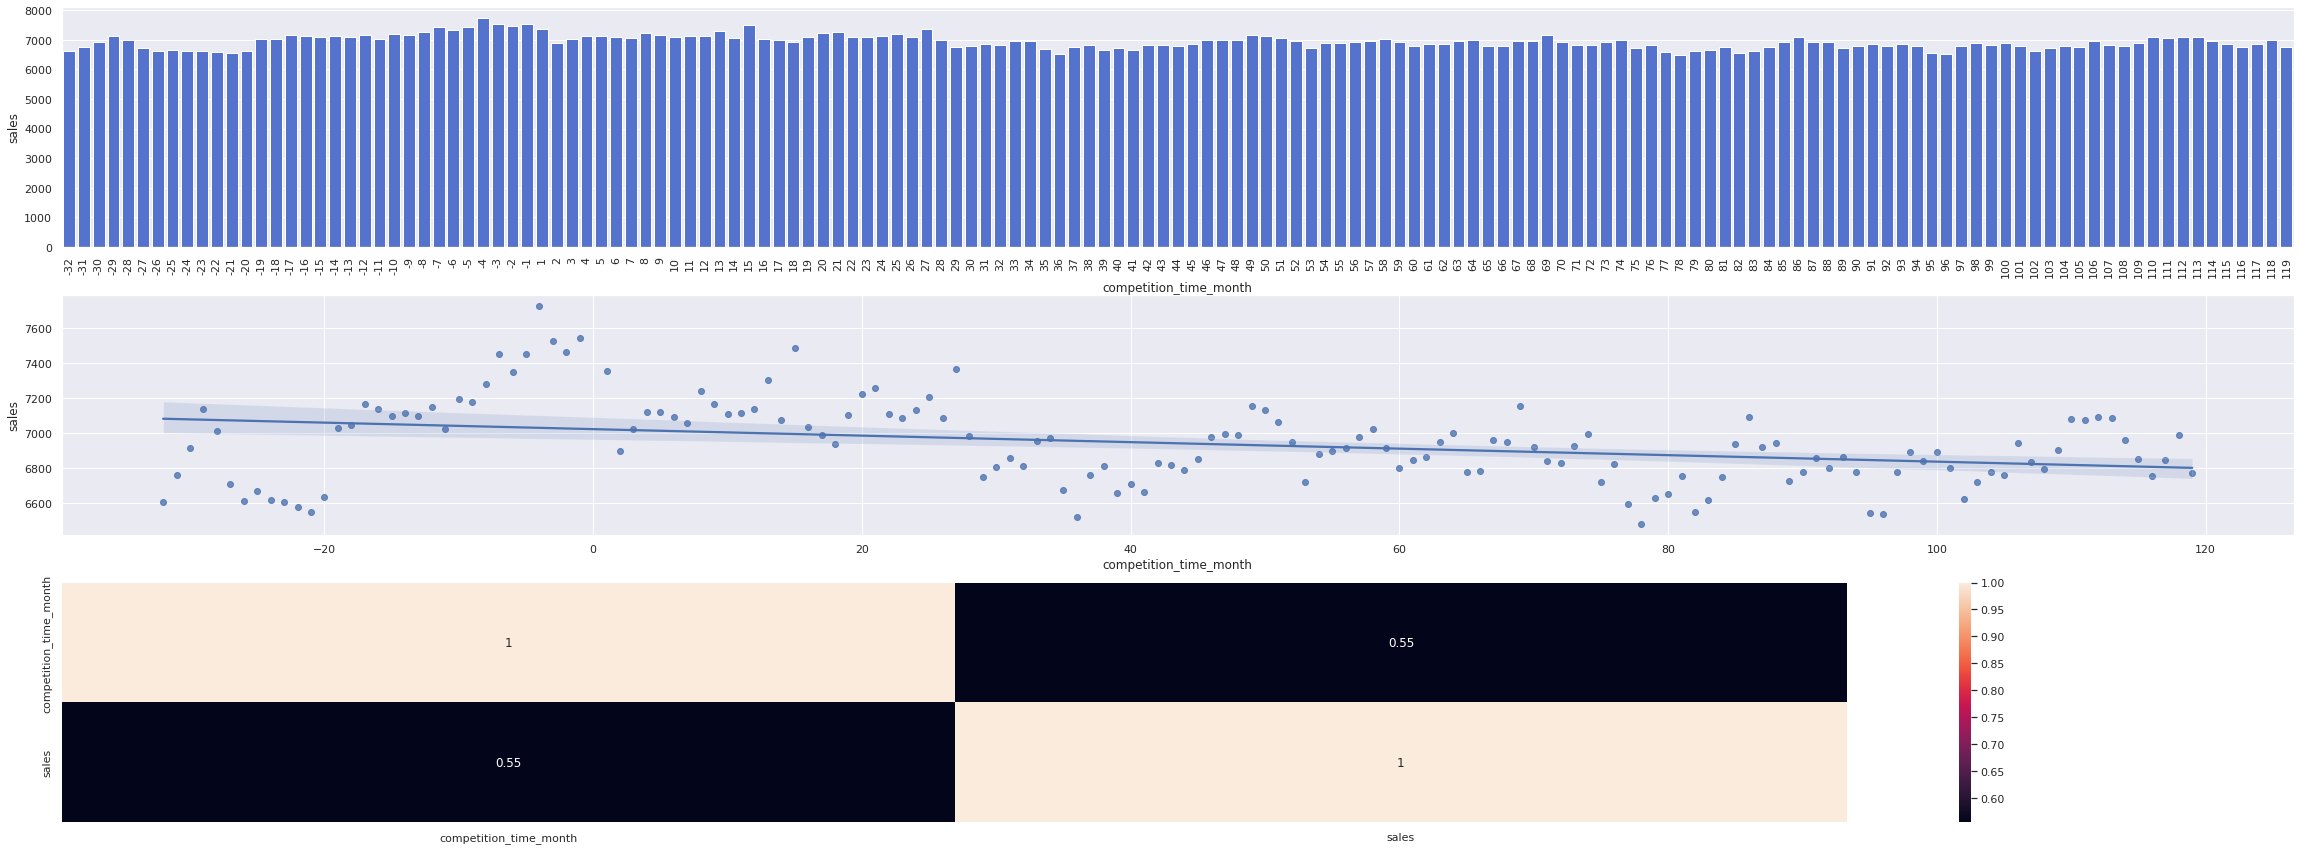

In [21]:
plt.subplot(3,1,1)
sns.barplot(data=comp_osm1, x='competition_time_month', y='sales', color='royalblue');
plt.xticks(rotation=90);

plt.subplot(3,1,2)
sns.regplot(data=comp_osm1, x='competition_time_month', y='sales');

plt.subplot(3,1,3)
sns.heatmap(comp_osm.corr(method='pearson'), annot=True);

#####  4. Lojas com promoções ativas por mais tempo deveriam vender mais.

    True. 
    Lojas com promoções ativas por muito tempo, tem uma queda considerável nas vendas após certo período mas ainda acima do valor médio.

In [22]:
promo_sales_geral = df[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
promo_sales = df.loc[df.promo_time_week > 0 ,['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
trad_sales = df.loc[df.promo_time_week < 0 ,['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

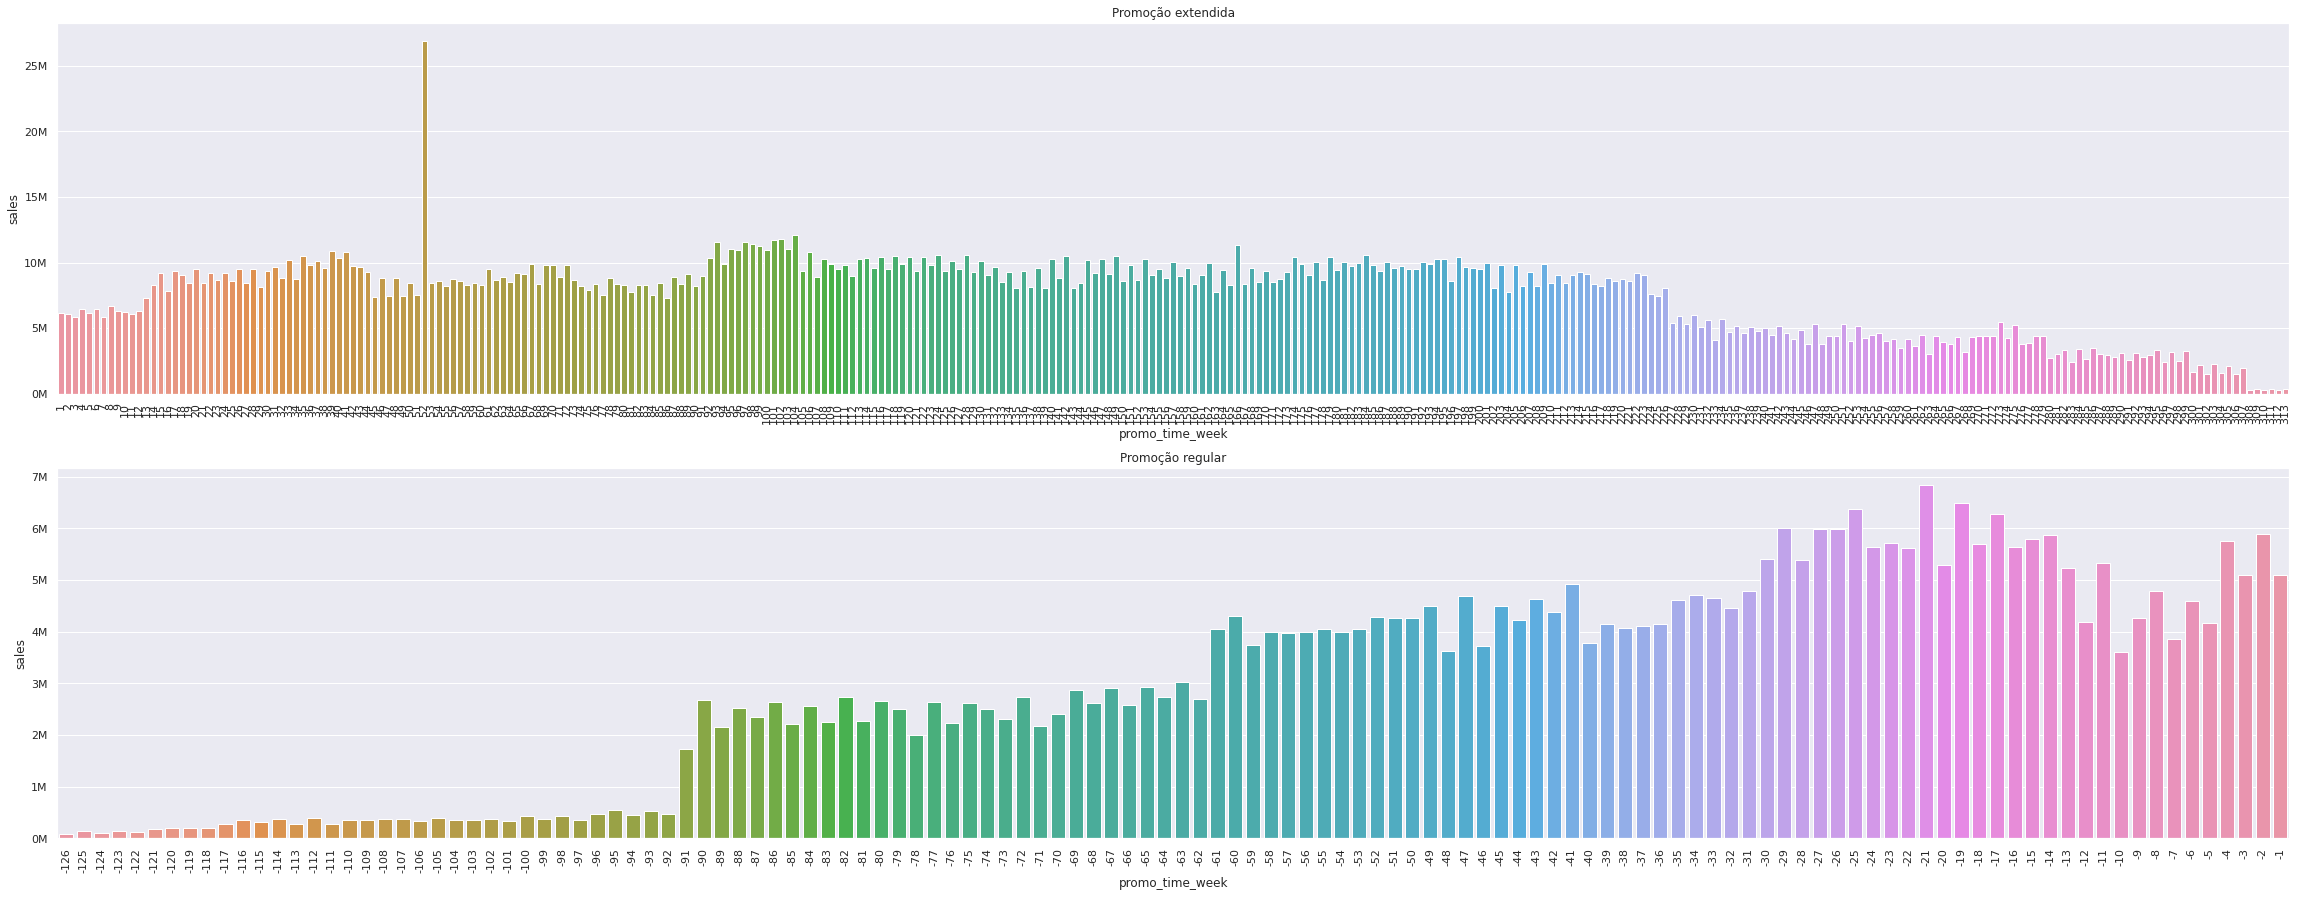

In [23]:
plt.subplot(2,1,1)
fig = sns.barplot(data=promo_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.xticks(rotation=90);
plt.title('Promoção extendida');

plt.subplot(2,1,2)
fig = sns.barplot(data=trad_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.xticks(rotation=90);
plt.title('Promoção regular');


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

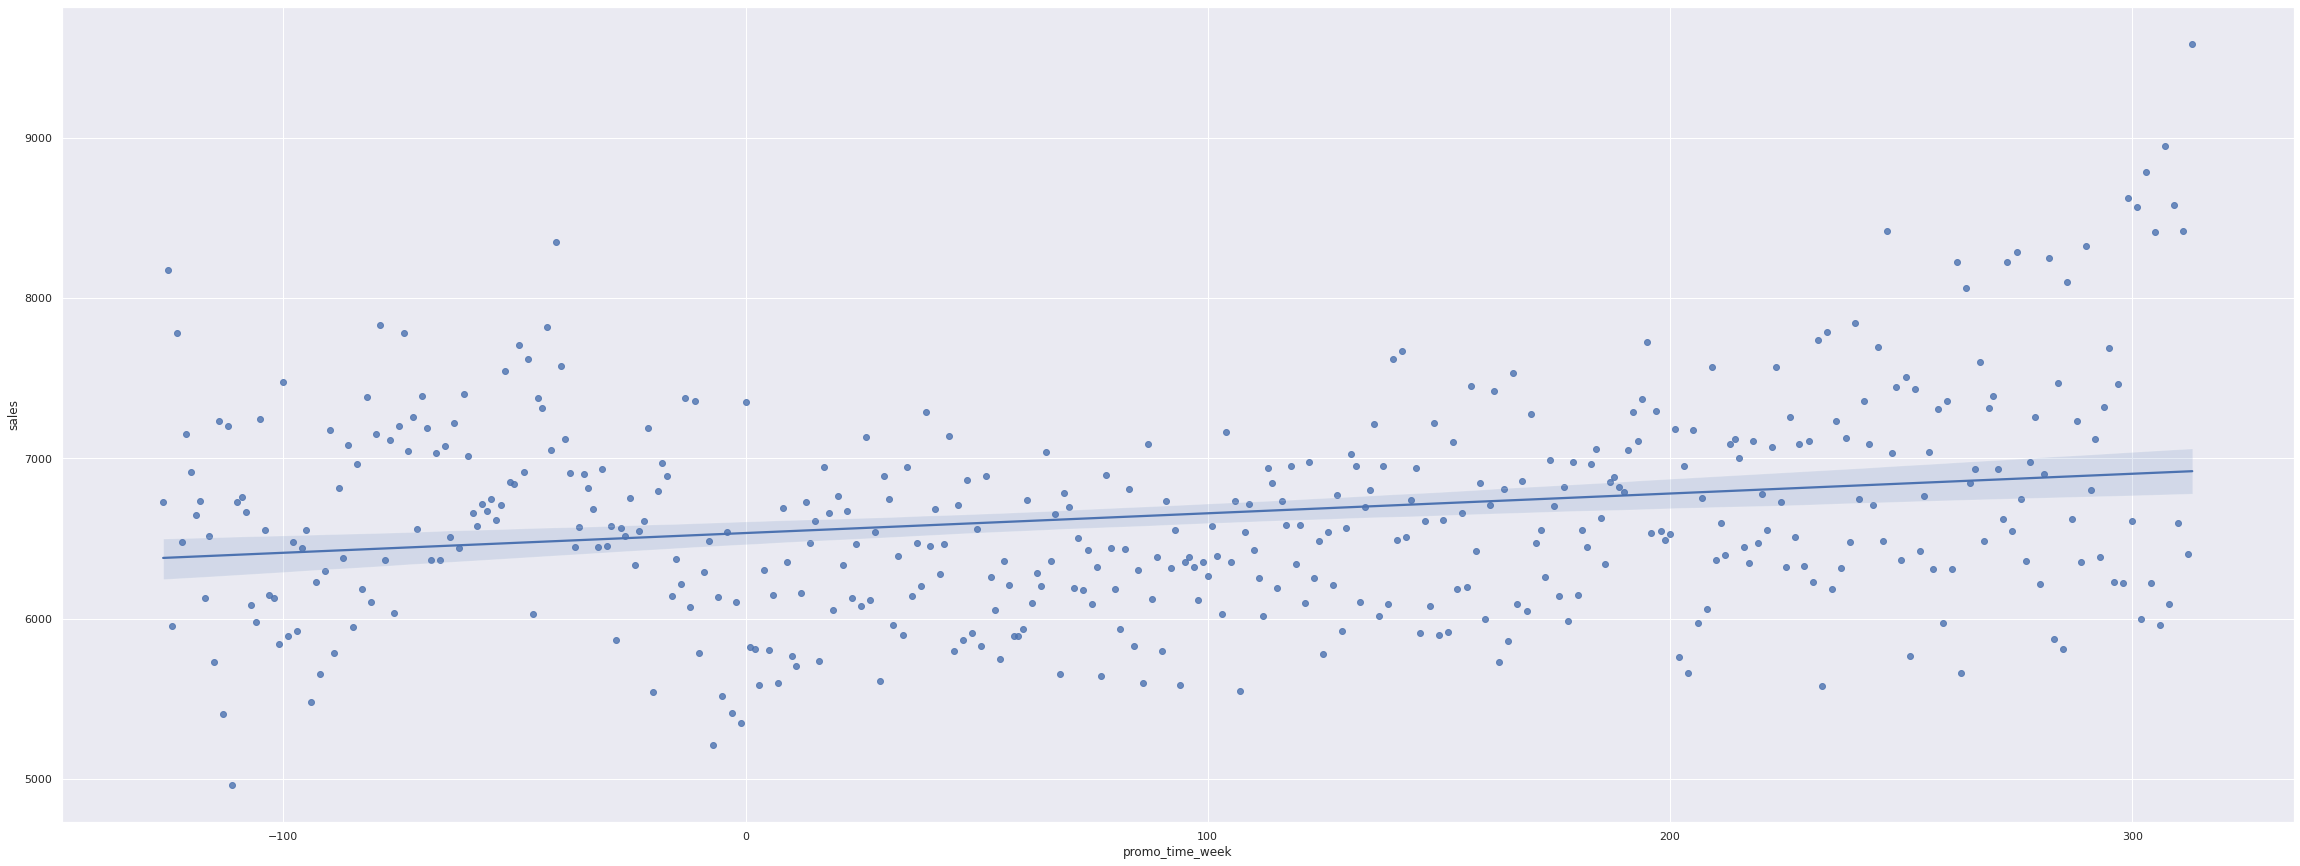

In [24]:
sns.regplot(data = promo_sales_geral, x= 'promo_time_week', y='sales')

<AxesSubplot:>

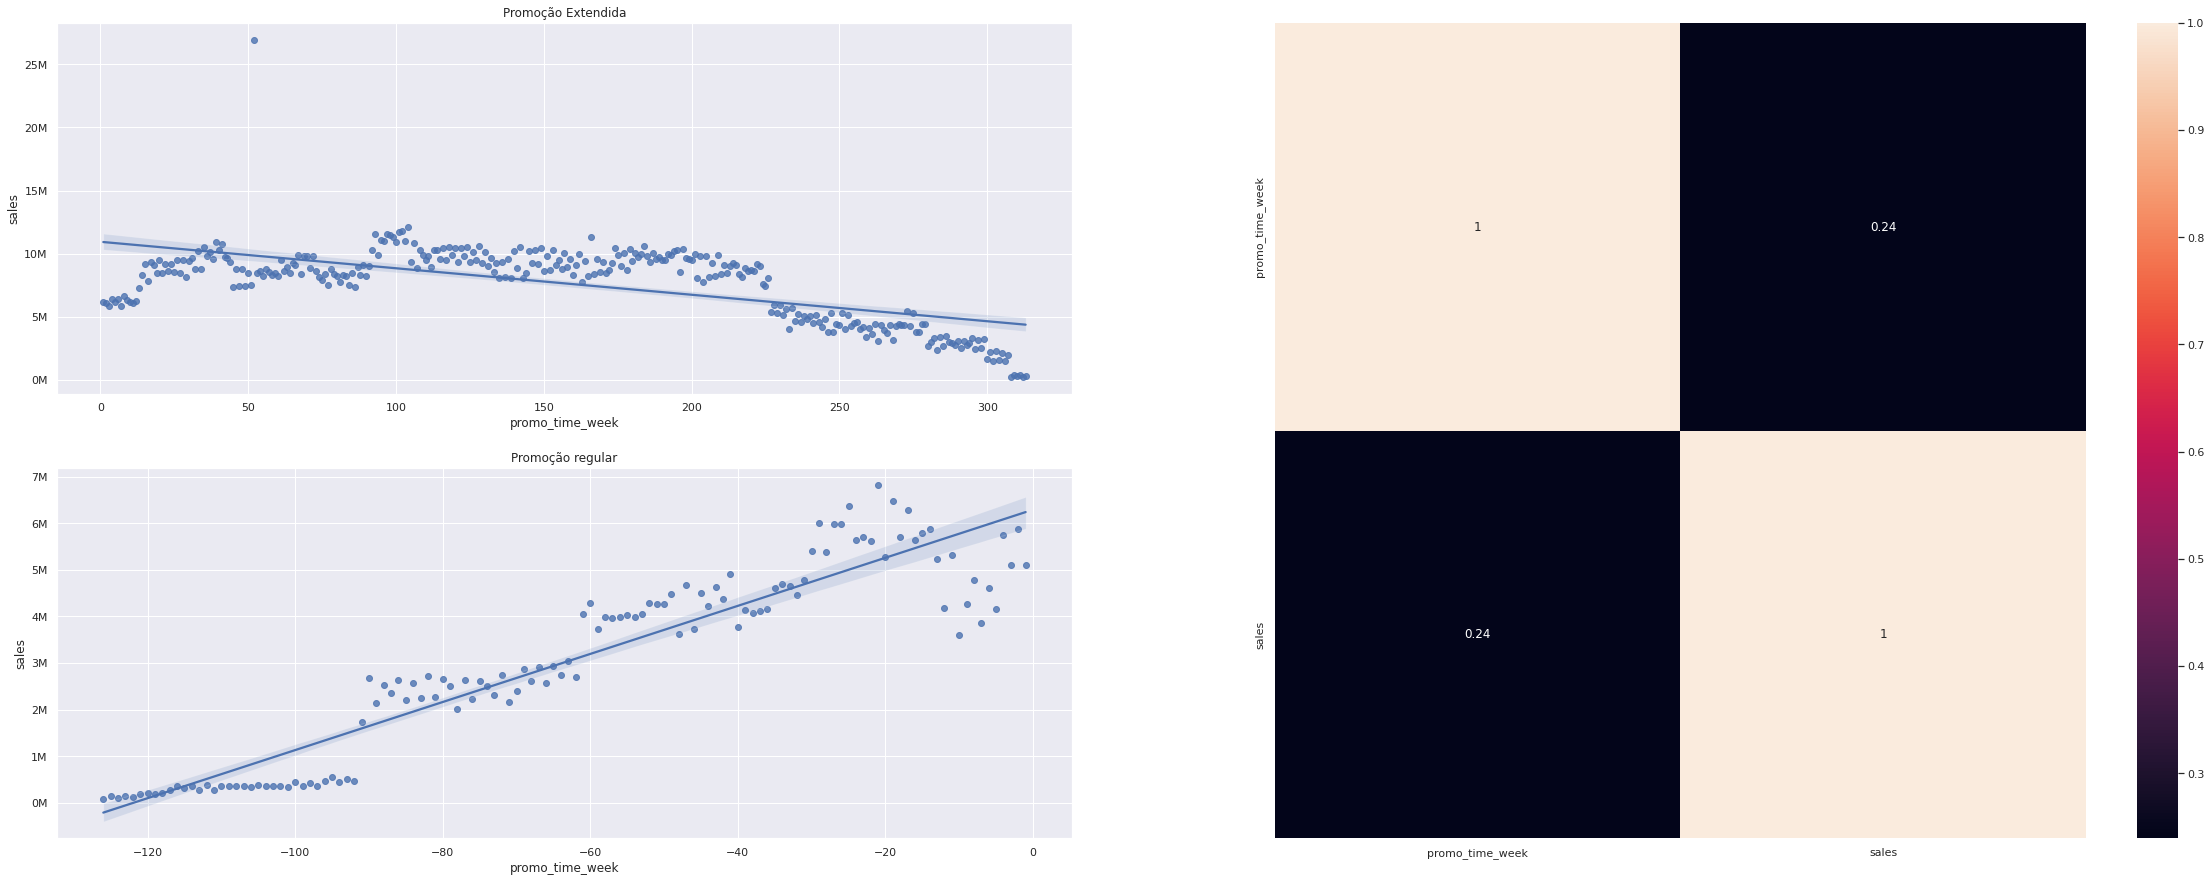

In [25]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
fig = sns.regplot(data=promo_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.title('Promoção Extendida');


plt.subplot(grid[1,0])
fig = sns.regplot(data=trad_sales, x='promo_time_week', y='sales');
xlabels = ['{:,.0f}'.format(x) + 'M' for x in fig.get_yticks()/1000000]
fig.set_yticklabels(xlabels);
plt.title('Promoção regular');

plt.subplot(grid[:,1])
sns.heatmap(promo_sales_geral.corr(method='pearson'), annot=True)



##### <s> 5. Lojas com mais dias de promoção deveriam vender mais. </s>    

##### 6. Lojas com mais promoções consecutivas deveriam vender mais.  

    False

In [26]:
df[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index().sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,8618.132880
3,1,1,7836.089044
0,0,0,6327.971557
1,0,1,5528.973894


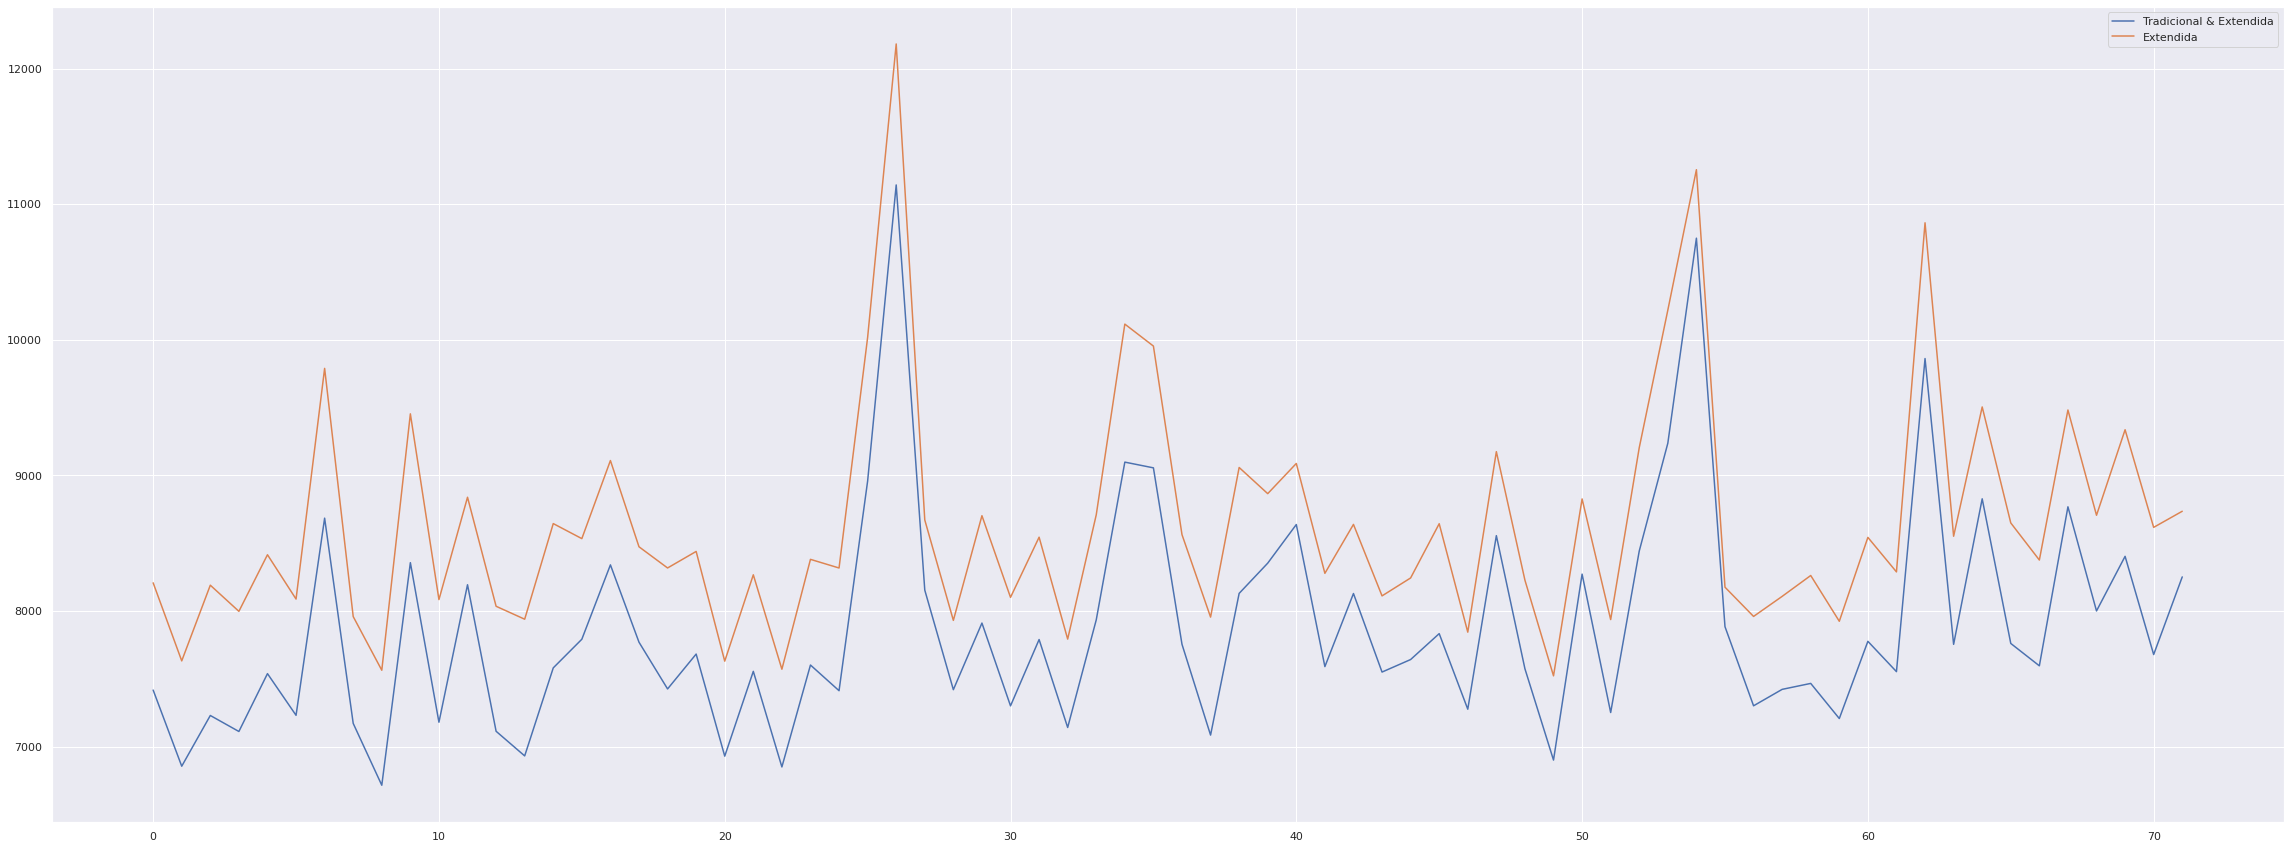

In [27]:
temp = df[(df['promo'] == 1) & (df['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = temp.plot()

temp1 = df[(df['promo'] == 1) & (df['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax2 = temp1.plot(ax = ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])


##### 7. Lojas que abrem durante o feriado de natal deveriam vender mais. 

    False
    Em um contexto geral, vende-se mais em 'easter_holiday' mas com uma pequena margem de diferênça.
    Se analisado isoladamente, em 2014 foram computadas mais vendas em 'christmas' do que nos demais.

<AxesSubplot:xlabel='year', ylabel='sales'>

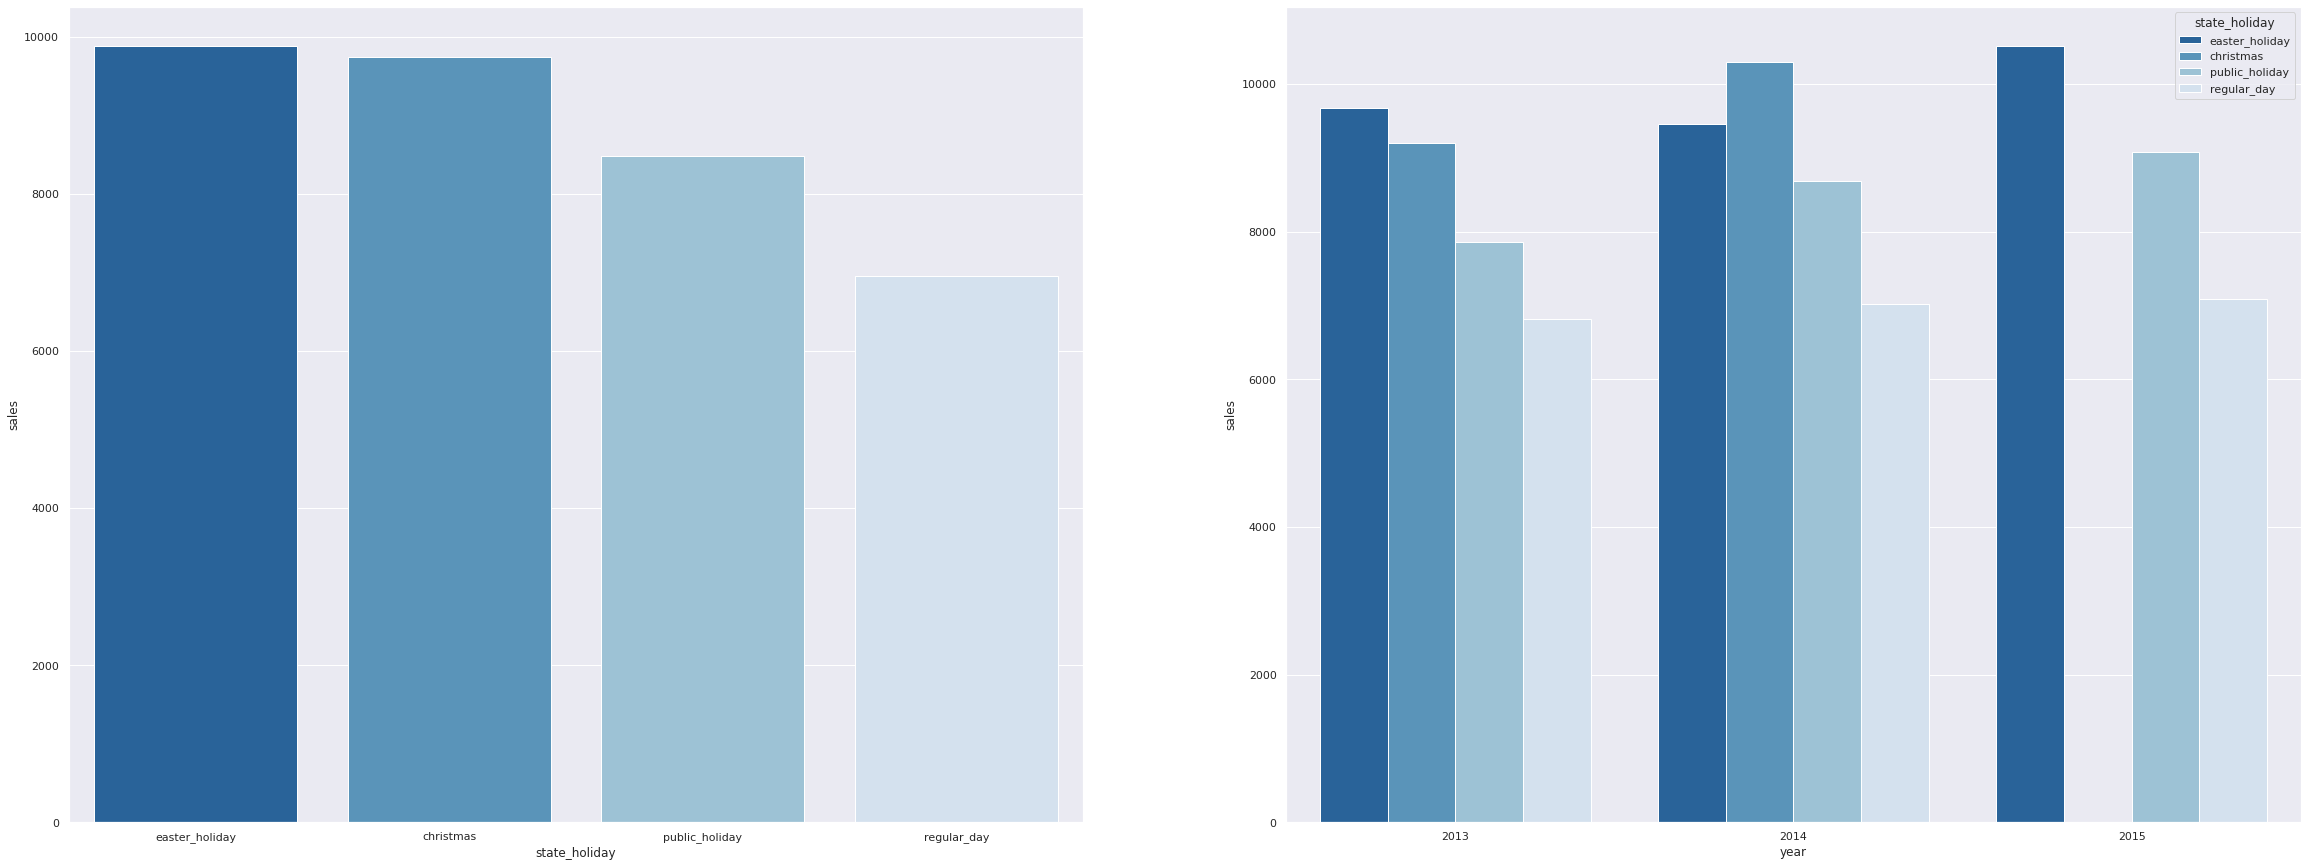

In [28]:
temp = df[['state_holiday', 'sales']].groupby('state_holiday').mean().sort_values('sales', ascending=False).reset_index()

#graph 1
plt.subplot(1,2,1)
sns.barplot(data=temp, x='state_holiday', y='sales', palette='Blues_r')

#graph2
temp1 = df[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).mean().sort_values('sales', ascending=False).reset_index()
plt.subplot(1,2,2)
sns.barplot(data=temp1, x='year', y='sales',hue='state_holiday', palette='Blues_r')


##### 8. Lojas deveriam vender mais ao longo dos anos.

    False. Com o passar dos anos, as lojas mostram uma clara tendência decrescente no montante de vendas.

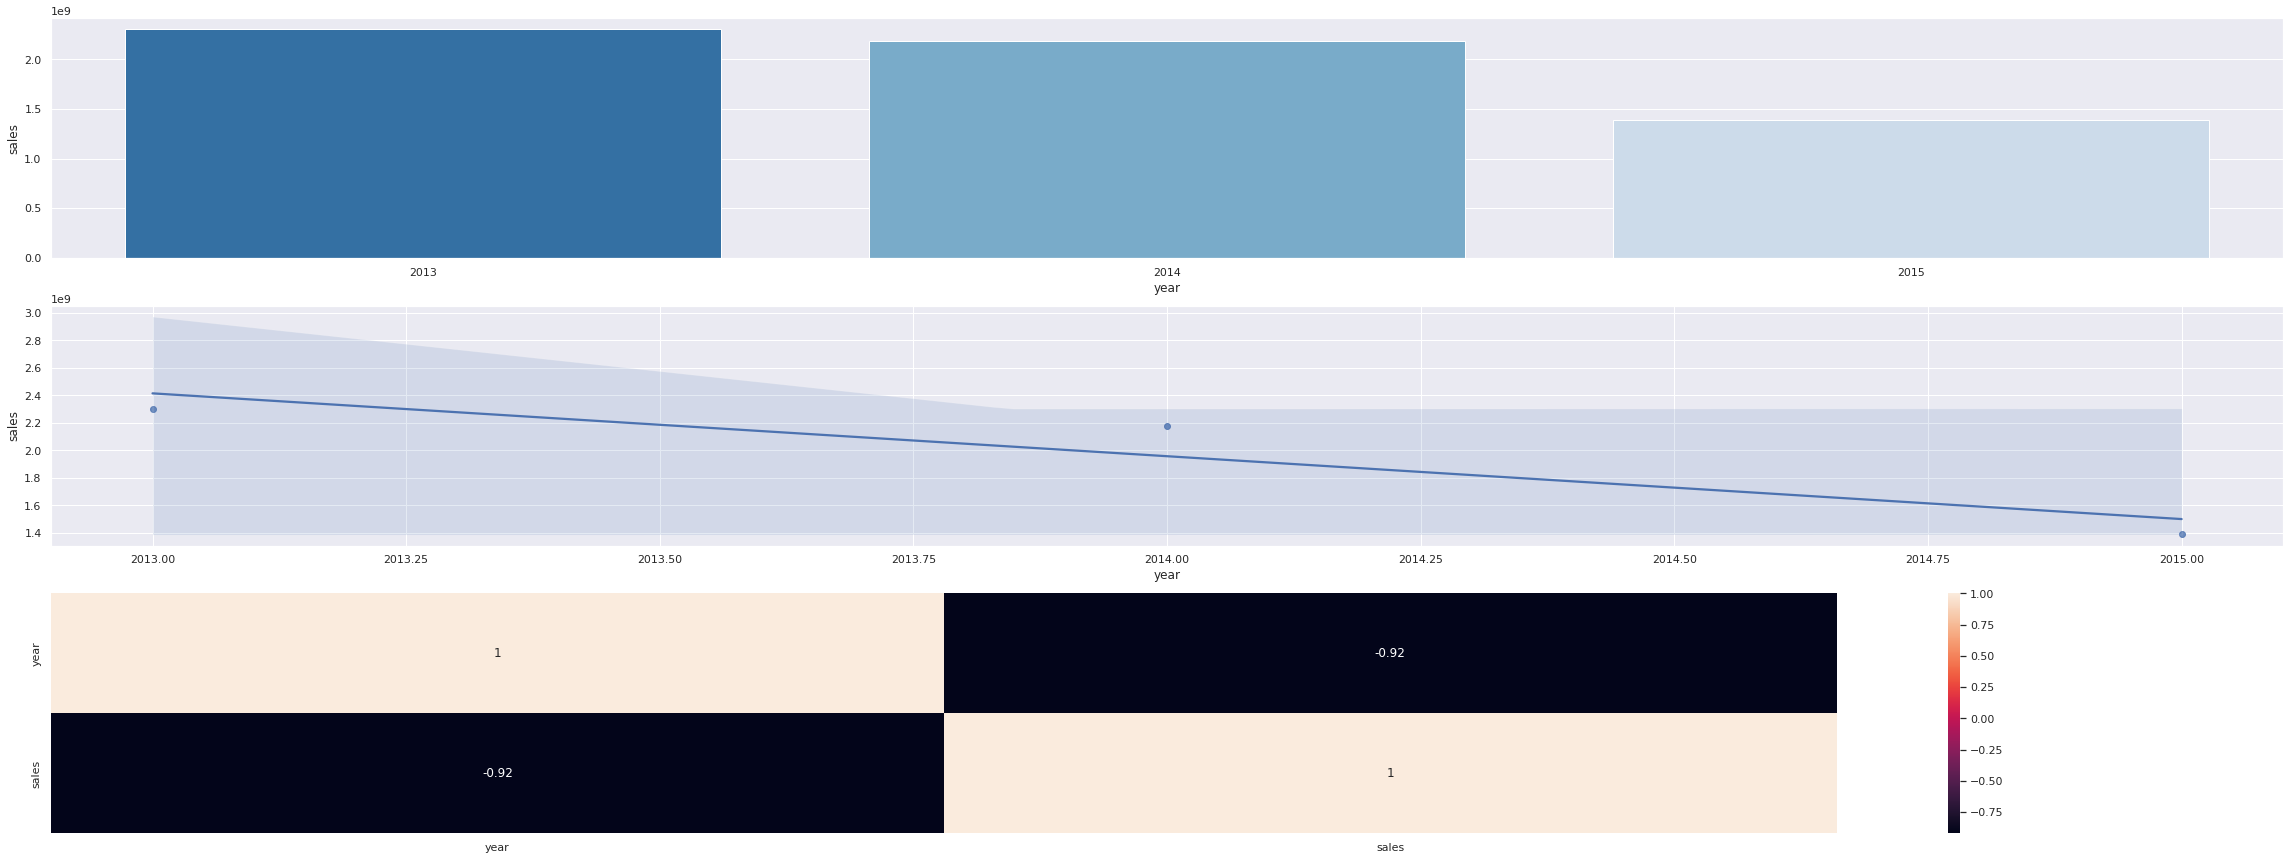

In [29]:
temp =  df[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(data=temp, x='year',y='sales', palette='Blues_r');

plt.subplot(3,1,2)
sns.regplot(data=temp, x='year',y='sales');

plt.subplot(3,1,3)
sns.heatmap(temp.corr(method='pearson'),annot=True);


##### 9. Lojas deveriam vender mais no segundo semestre do ano.

    Verdadeiro. Se for desconsiderado o ano de 2015(que está com informações referentes somente até o mês 7), nota-se uma pequeno nível de crescimento 

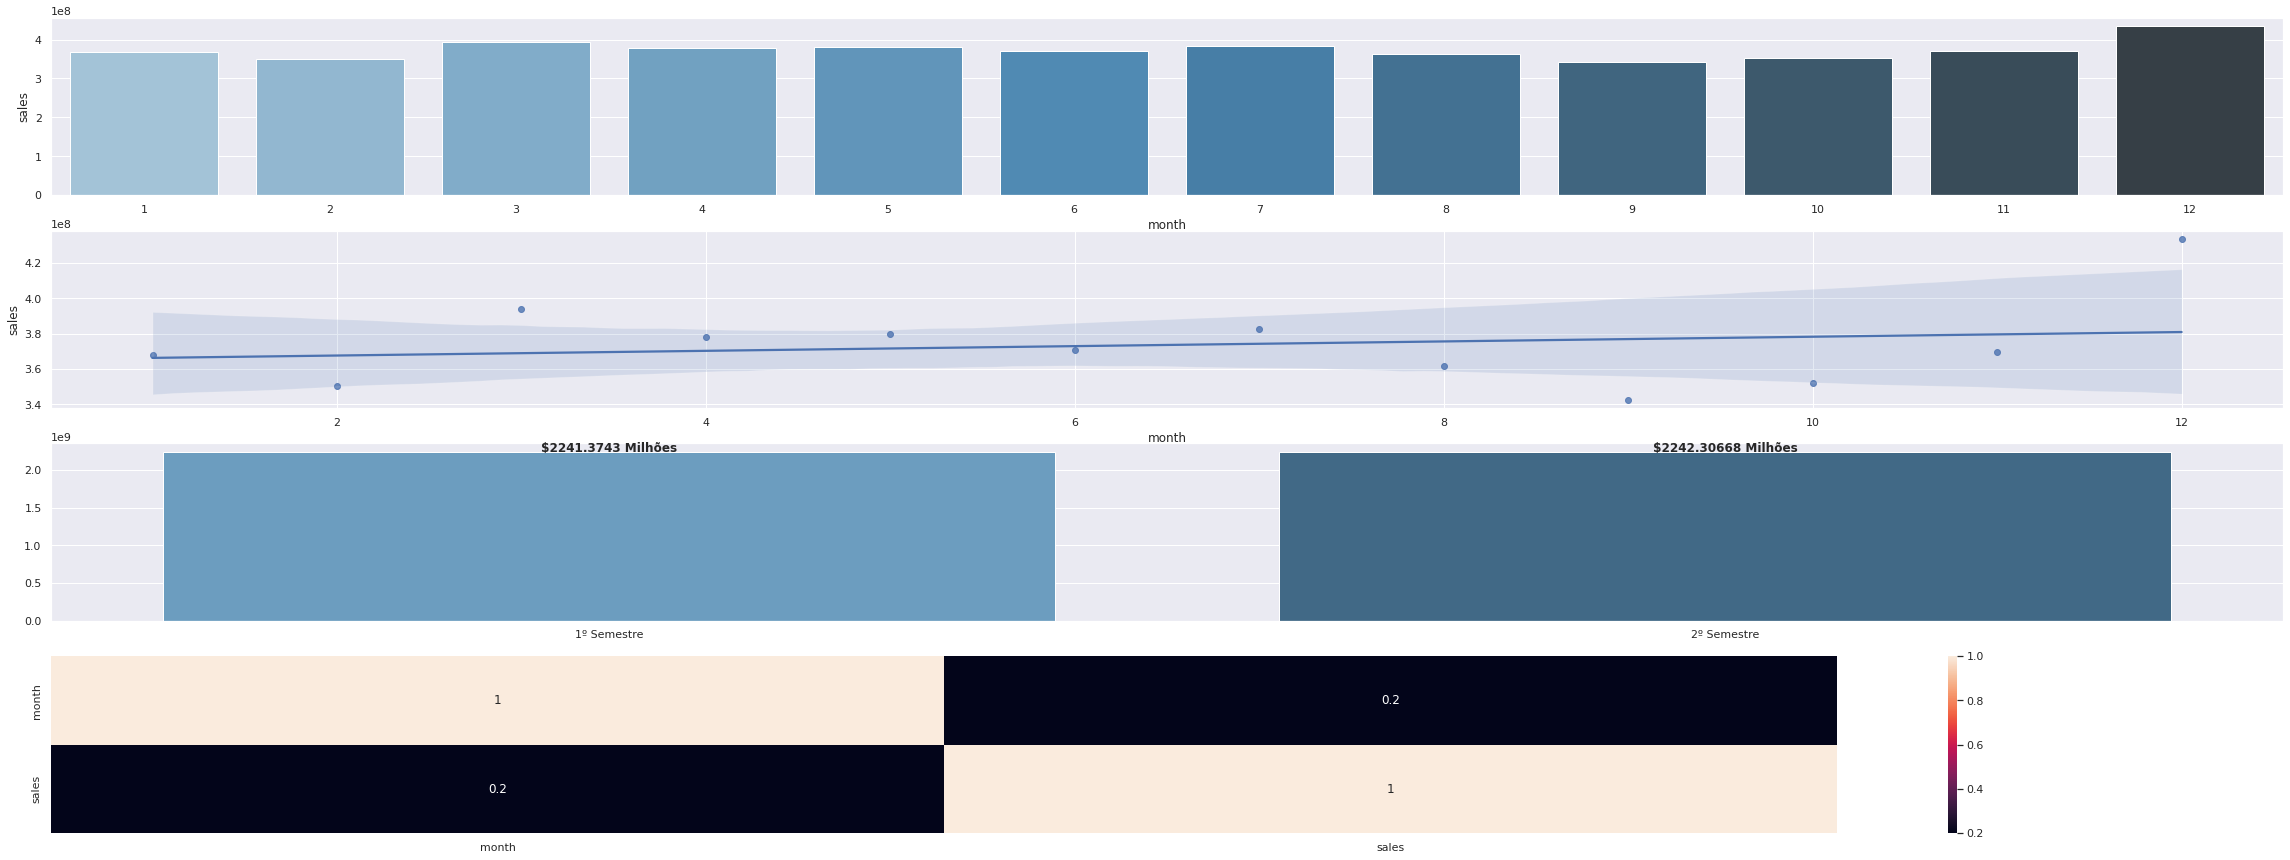

In [30]:
temp = df.loc[df['year'] < 2015, ['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='month', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='month', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['1º Semestre', '2º Semestre'], y=[temp.loc[temp['month'] <= 6, 'sales'].sum(),temp.loc[temp['month'] >= 7, 'sales'].sum()], palette='Blues_d')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height() / 1000000) + ' Milhões',
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );


##### 10. Lojas deveriam vender mais após o dia 10 de cada mês.

    False. Lojas tem média de vendas maior, antes do dia 10

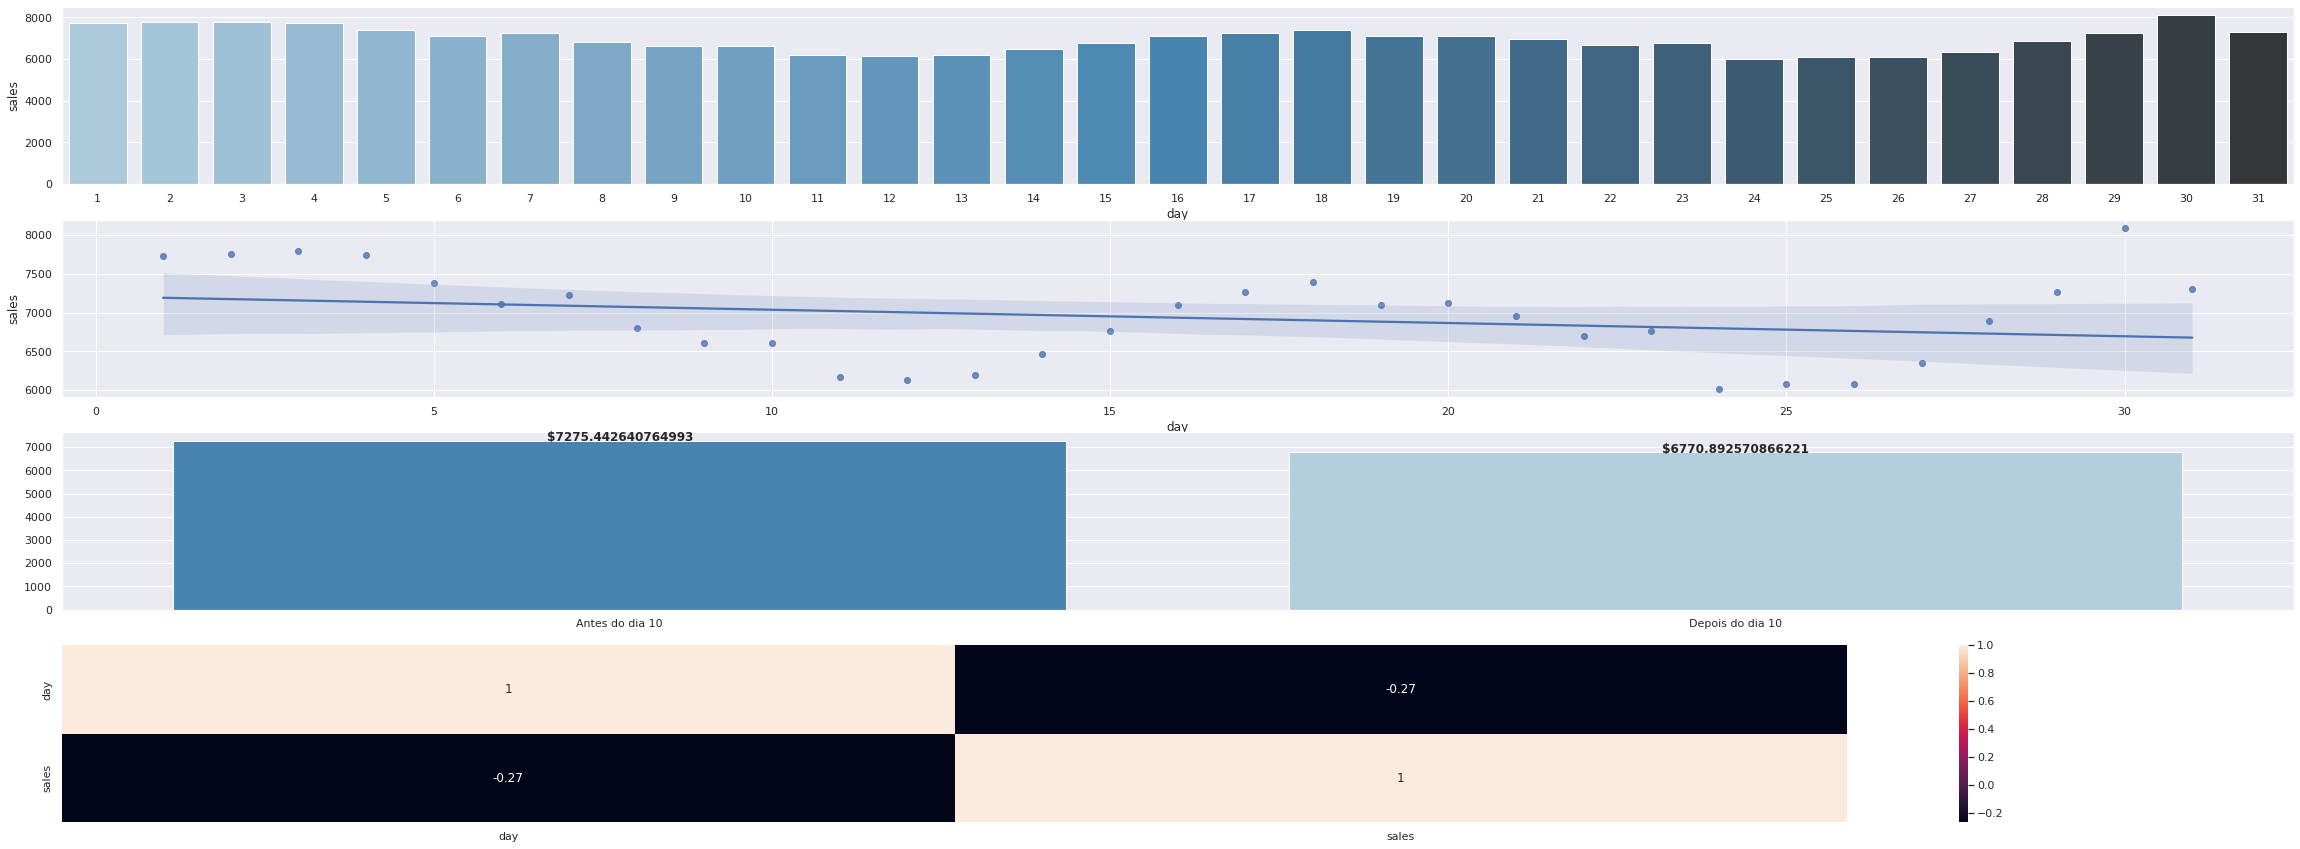

In [31]:
temp = df.loc[df['year'] < 2015, ['day', 'sales']].groupby('day').mean().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='day', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='day', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['Antes do dia 10', 'Depois do dia 10'], y=[temp.loc[temp['day'] <= 10, 'sales'].mean(),temp.loc[temp['day'] > 10, 'sales'].mean()], palette='Blues_r')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height()),
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );

##### 11. Lojas deveriam vender menos aos fins de semana.

    True.
    Lojas tem uma média menor de vendas aos fins de semana

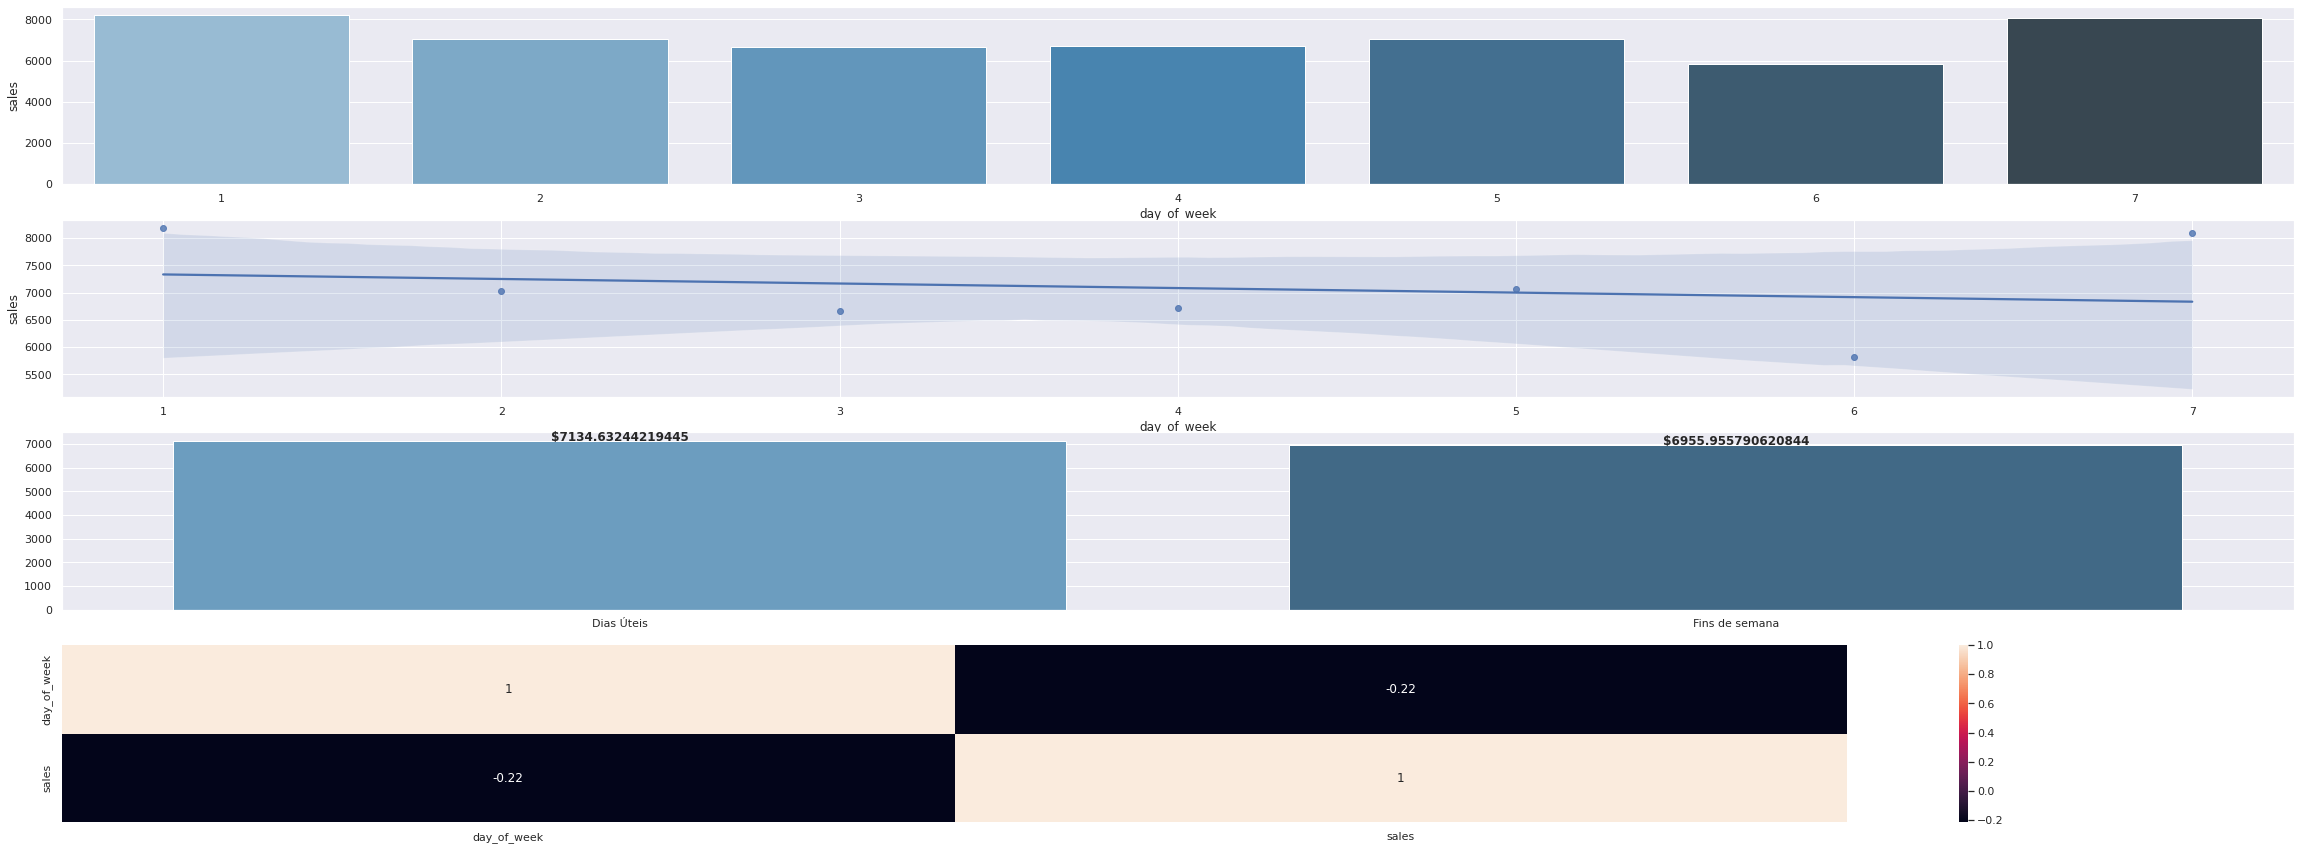

In [32]:
temp = df.loc[df['year'] < 2015, ['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(4,1,1)
sns.barplot(data=temp, x='day_of_week', y='sales', palette='Blues_d')

plt.subplot(4,1,2)
sns.regplot(data=temp, x='day_of_week', y='sales')

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(4,1,3)
ax = sns.barplot(data=temp, x=['Dias Úteis', 'Fins de semana'], y=[temp.loc[temp['day_of_week'] <= 5, 'sales'].mean(),temp.loc[temp['day_of_week'] > 5, 'sales'].mean()], palette='Blues_d')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height()) ,
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );


##### 12. Lojas deveriam vender menos durante o feriados escolares.

    Falso. 
    Lojas tem uma média maior de vendas em feriados escolares. O que se repete por todo ano menos no mês de setembro onde as vendas são iguais e  Dezembro onde as vendas dos dias letivos, superam.

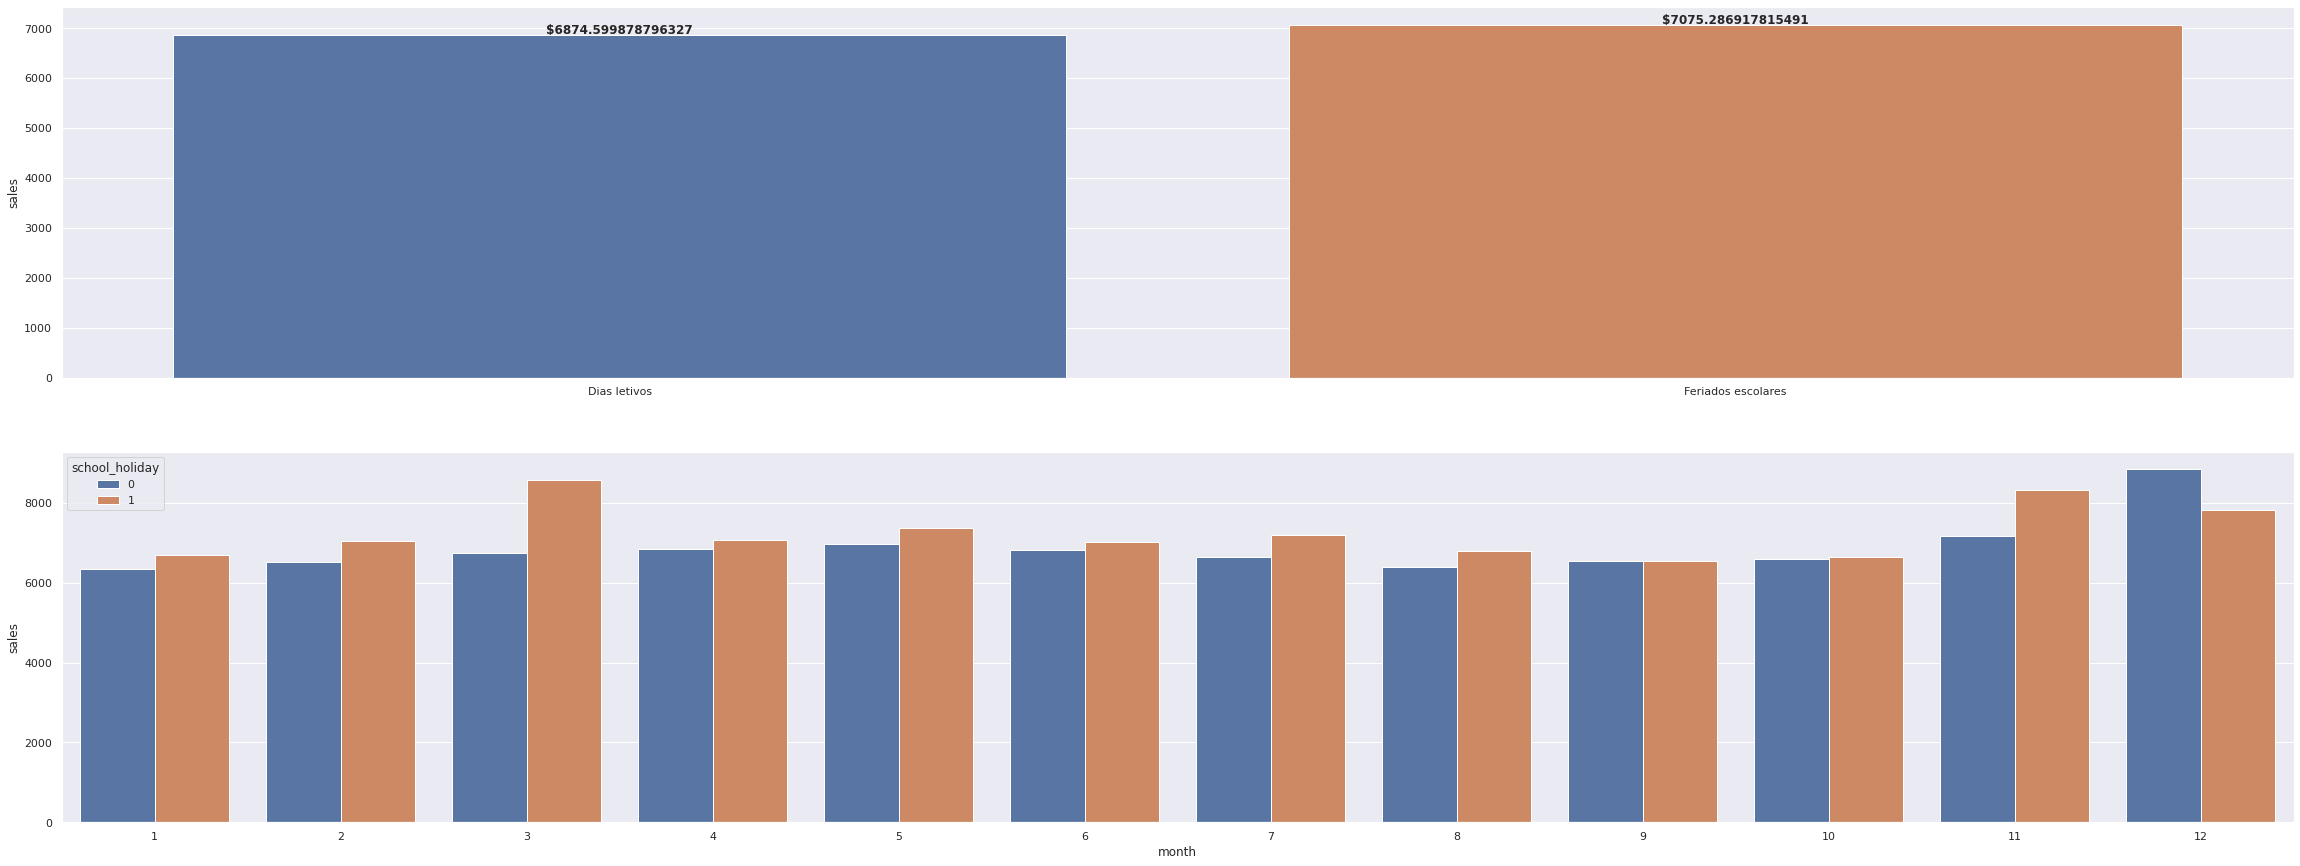

In [33]:
temp = df.loc[df['year'] < 2015, ['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
temp1 = df.loc[df['year'] < 2015, ['month','school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()


plt.subplot(2,1,1)
ax = sns.barplot(data=temp, x=['Dias letivos', 'Feriados escolares'], y='sales')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height())  ,
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + 10),
        ha='center' ,
        weight='bold'       
     );

plt.subplot(2,1,2)
ax1 = sns.barplot(data=temp1, x='month', y='sales', hue='school_holiday')





#### 4.1. Análise Multivariada

##### 4.1.1 Numerical Attributes

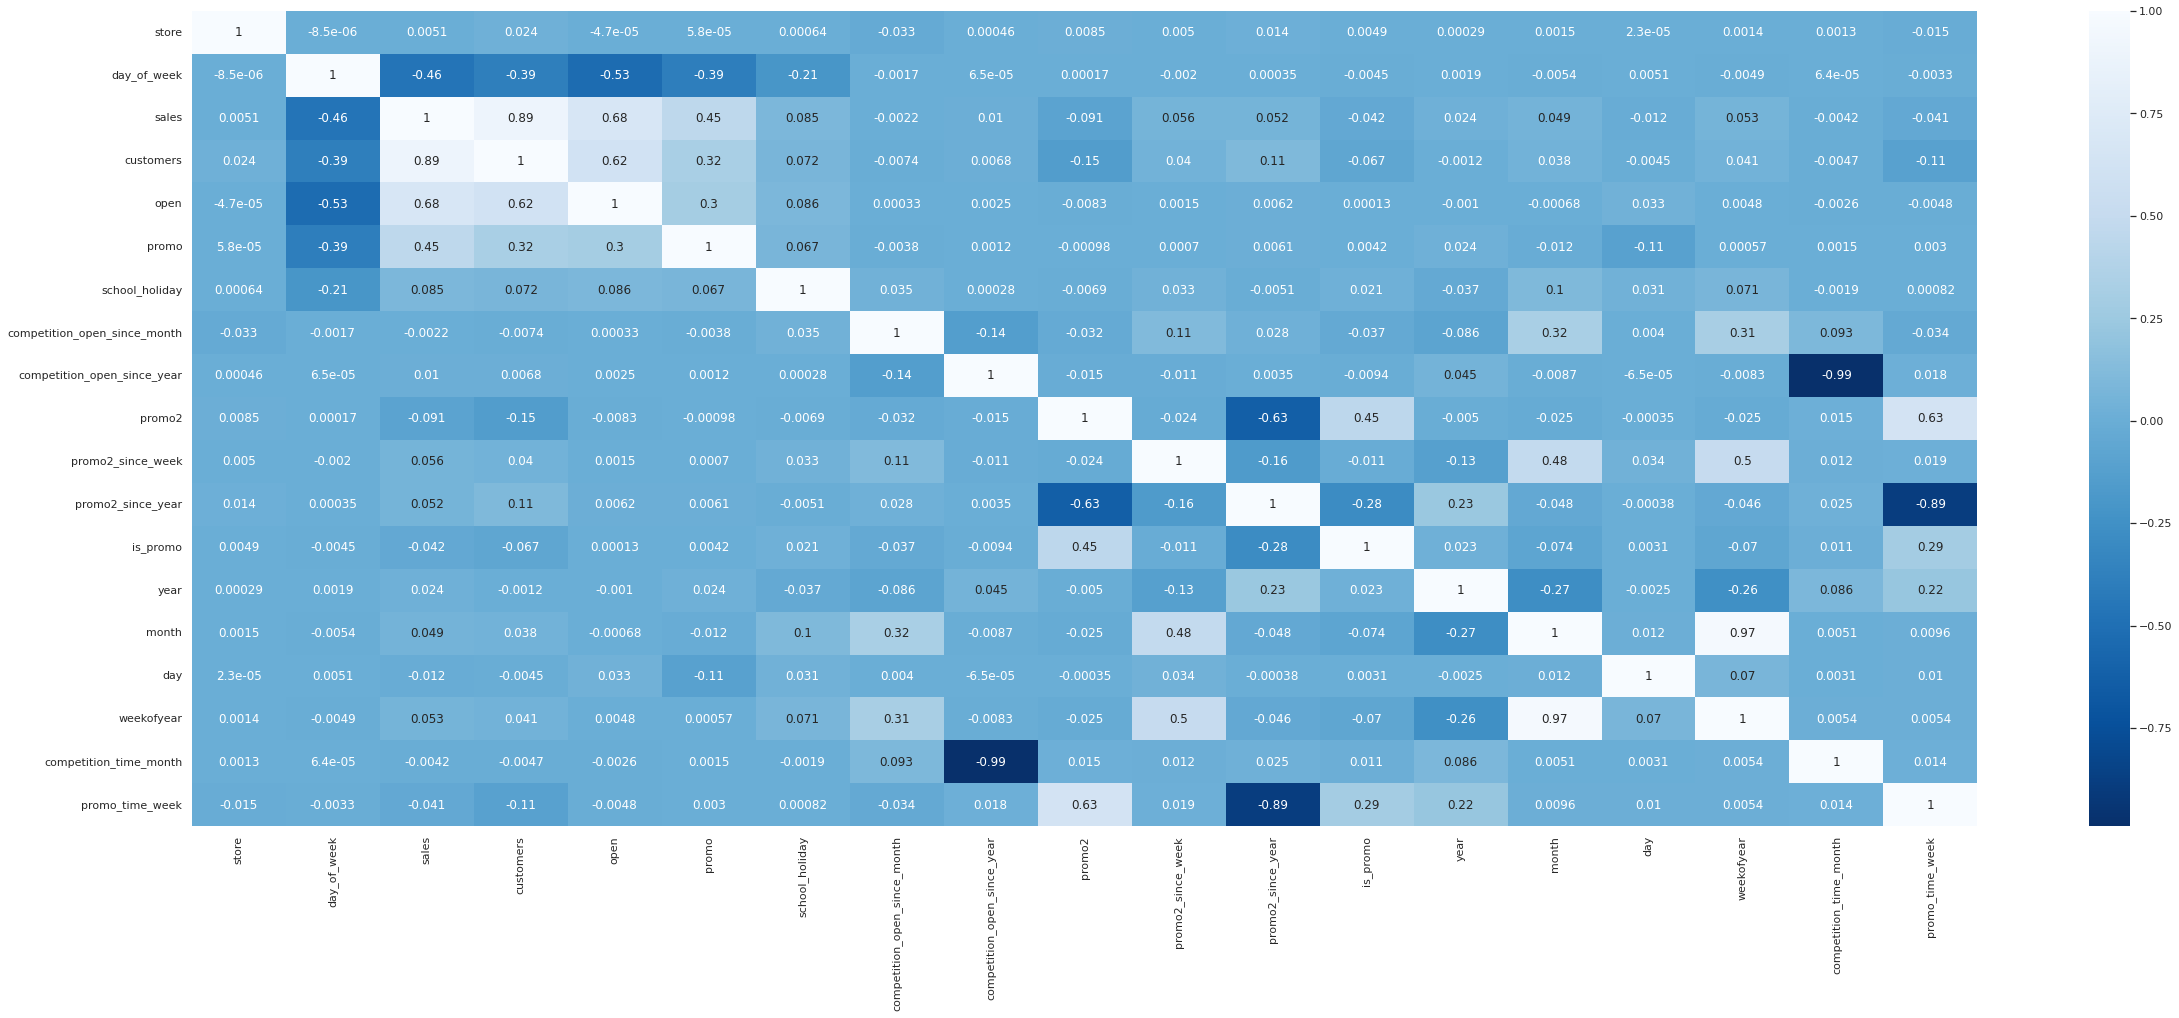

In [34]:
correlation = num_atributes.corr(method='pearson')

sns.heatmap(correlation, annot=True, cmap='Blues_r');

In [35]:
cat_atrib = df.select_dtypes(include='object')
cat_atrib = cat_atrib.drop(columns=['year_week'])

    - Cramés V

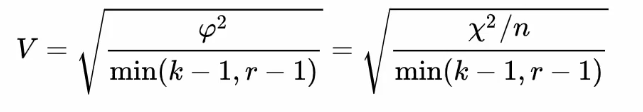

In [36]:
Image('img/formula.png')

In [37]:
a1 = cramer_v(cat_atrib['state_holiday'], cat_atrib['state_holiday'])
a2 = cramer_v(cat_atrib['state_holiday'], cat_atrib['store_type'])
a3 = cramer_v(cat_atrib['state_holiday'], cat_atrib['assortment'])

a4 = cramer_v(cat_atrib['store_type'], cat_atrib['state_holiday'])
a5 = cramer_v(cat_atrib['store_type'], cat_atrib['store_type'])
a6 = cramer_v(cat_atrib['store_type'], cat_atrib['assortment'])

a7 = cramer_v(cat_atrib['assortment'], cat_atrib['state_holiday'])
a8 = cramer_v(cat_atrib['assortment'], cat_atrib['store_type'])
a9 = cramer_v(cat_atrib['assortment'], cat_atrib['assortment'])

In [38]:
d = pd.DataFrame(
    {
        'state_holiday' : [a1,a2,a3],
        'store_type' : [a4,a5,a6],
        'assortment' : [a7,a8,a9],
    }
)
d = d.set_index(d.columns)

<AxesSubplot:>

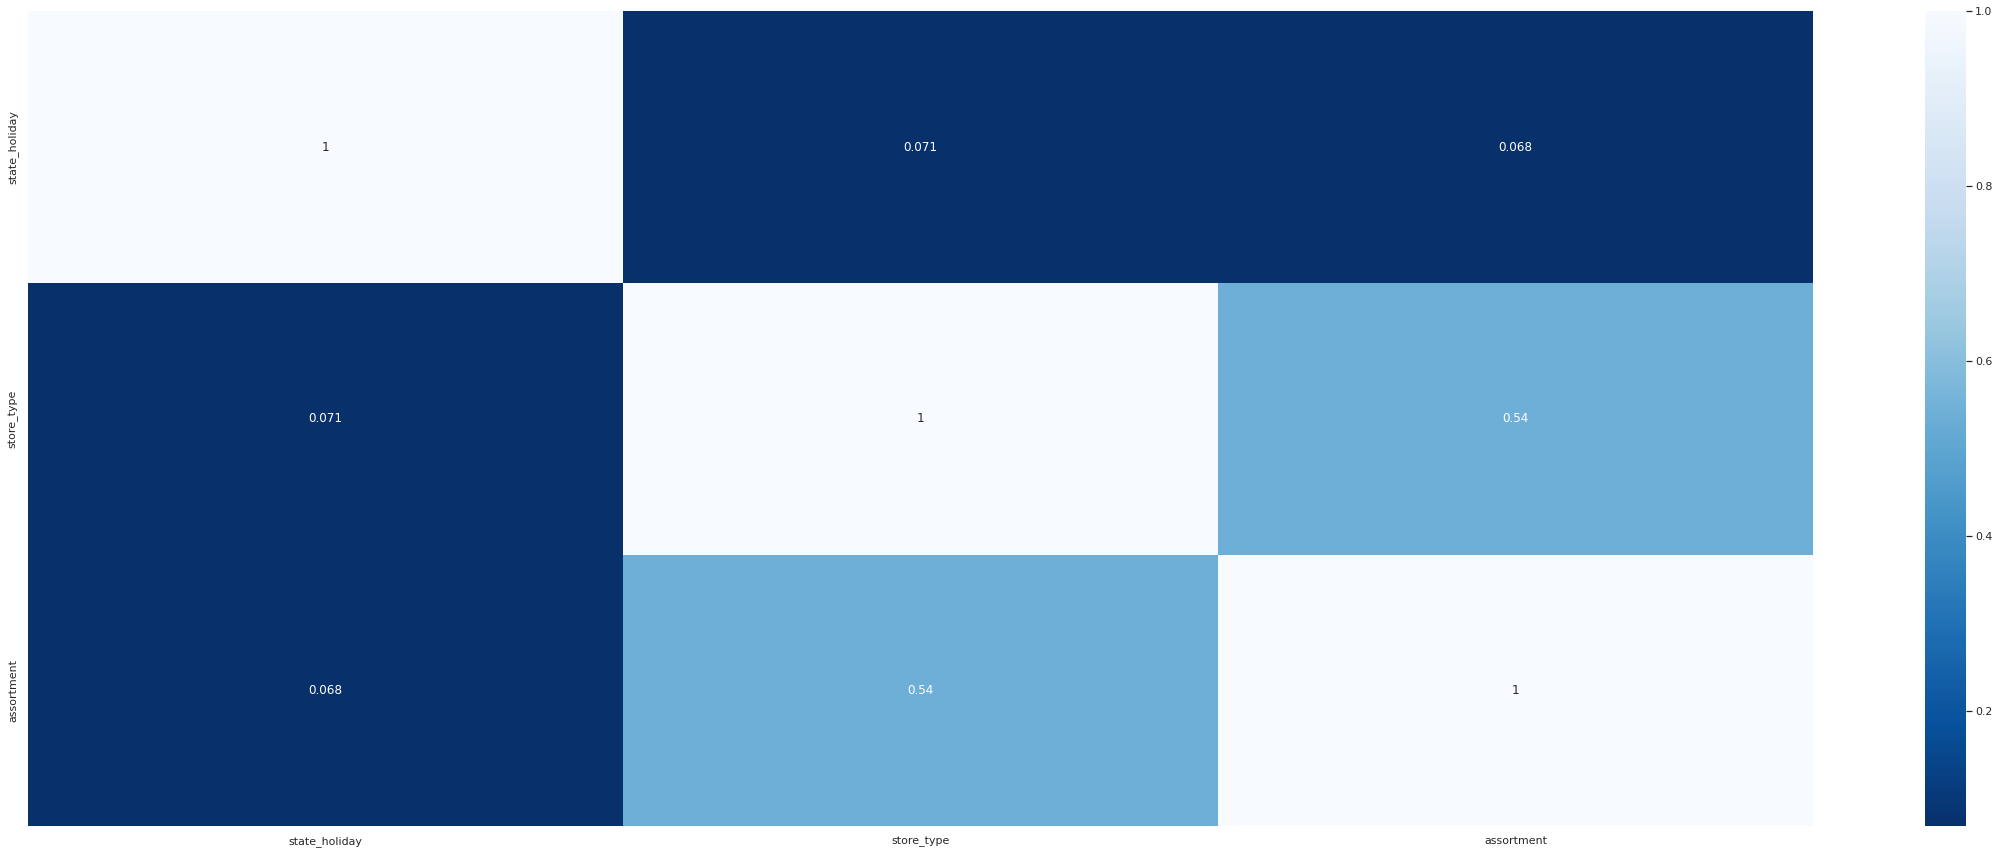

In [39]:
sns.heatmap(d, annot=True, cmap='Blues_r')

### 5.0. Preparação dos dados 

In [40]:
#Fazendo um bkp dos dados trabalhados até o momento
df1 = df.copy()

#### 5.1. Normalização

    Como não temos variáveis com distribuição normal, não será efetuado esse processo 

#### 5.2. Rescaling

    Robust Scaler

    Primeiro será aplicado o modelo em variáveis que não possuem natureza cíclica.

<AxesSubplot:xlabel='competition_distance'>

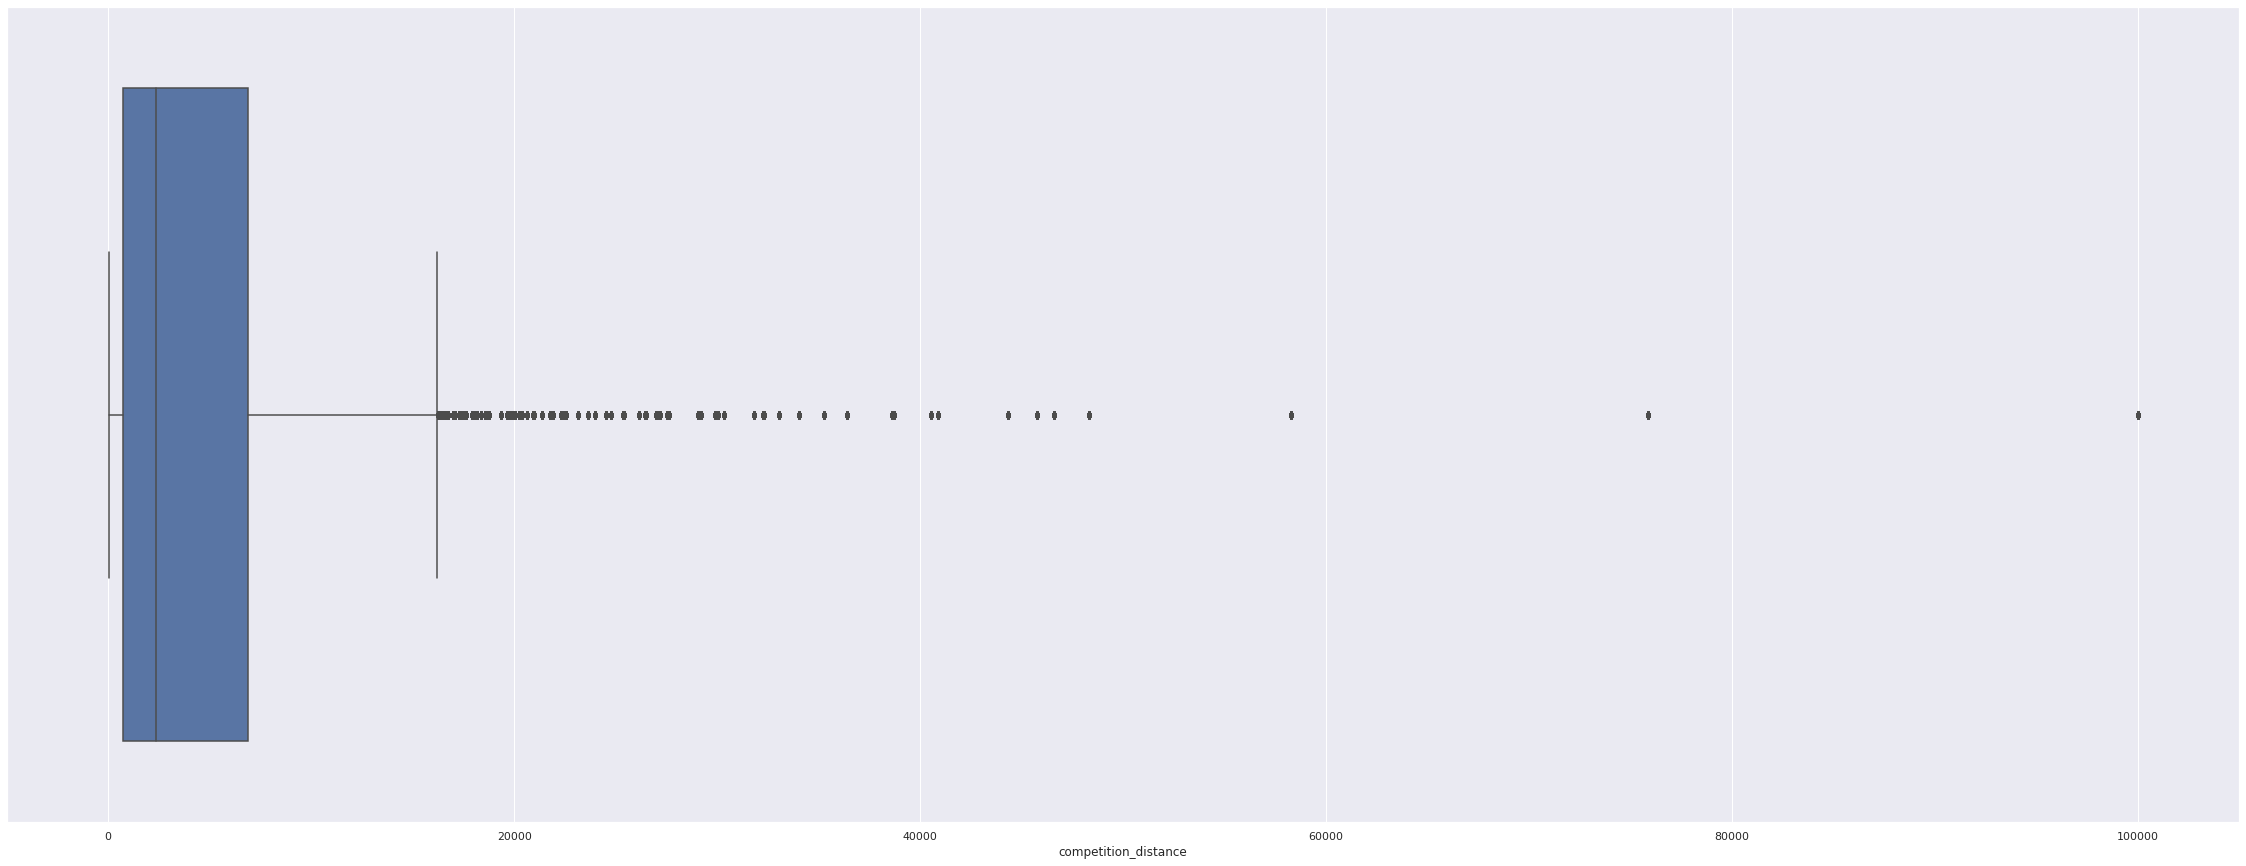

In [41]:
# Análise de outliers das variáveis
sns.boxplot(df1.competition_distance)

#### 5.2.1 Robust Scaler

In [42]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df1['competition_distance'] =rs.fit_transform(df1[['competition_distance']].values)

#competition_time_month
df1['competition_time_month'] =rs.fit_transform(df1[['competition_time_month']].values)

#promo_time_week | (Como não há outliers relevantes, será utilizado o MinMaxScaler)
df1['promo_time_week'] =mms.fit_transform(df1[['promo_time_week']].values)

#year  | (Por não conter outlier, também será usado o MMS)
df1['year'] =mms.fit_transform(df1[['year']].values)




#### 5.3 Encoding

In [43]:
#state_holiday | One hot encoding
df1 = pd.get_dummies(df1, prefix=['state_holiday'], columns=['state_holiday'])

#store_type | Label encoding - (Por não haver ordem de grandeza, será usado o Label encodin)
le = LabelEncoder()
df1['store_type'] = le.fit_transform(df1['store_type'])

#assortment | Ordinal encoding  - (Como há uma ordem, será utilizado esse método)
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df1.assortment = df1.assortment.map(assortment_dict)

#### 5.3.1 Response variable transformation

In [44]:
#Transformação da target
df1['sales'] = np.log1p(df1['sales'])

#### 5.3.2 Nature Transformation

In [45]:
#day_of_week
df1['day_of_week_sin'] = df1['day_of_week'].apply(lambda x: np.sin( x* (2. * np.pi/7 ) ) )
df1['day_of_week_cos'] = df1['day_of_week'].apply(lambda x: np.cos( x* (2. * np.pi/7 ) ) )

#month
df1['month_sin'] = df1['month'].apply(lambda x: np.sin( x* (2. * np.pi/12 ) ) )
df1['month_cos'] = df1['month'].apply(lambda x: np.cos( x* (2. * np.pi/12 ) ) )

#day
df1['day_sin'] = df1['day'].apply(lambda x: np.sin( x* (2. * np.pi/30 ) ) )
df1['day_cos'] = df1['day'].apply(lambda x: np.cos( x* (2. * np.pi/30 ) ) )

#week_of_year
df1['weekofyear_sin'] = df1['weekofyear'].apply(lambda x: np.sin( x* (2. * np.pi/52 ) ) )
df1['weekofyear_cos'] = df1['weekofyear'].apply(lambda x: np.cos( x* (2. * np.pi/52 ) ) )

### 6.0. Seleção de variáveis

In [46]:
df1.promo

0          1
1          1
2          1
3          1
4          1
          ..
1016776    0
1016827    0
1016863    0
1017042    0
1017190    0
Name: promo, Length: 844392, dtype: int64

In [47]:
### Bkup
df2 = df1.drop(columns=['weekofyear','day','month','day_of_week', 'promo_since', 'competition_since', 'year_week']).copy()

#### 6.1 Train Test Split

In [48]:
###Como o cálculo será da previsão de 6 semanas, vamos seprara o DF em treino (Antes das 6 semanas) e tese (As últimas 6 semanas existentes no DF).
## Calculando data máxima de venda e qual seria o período de corte no DF
df2[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [82]:
### Separando em conjutos de Treino
X_train = df2[df2['date'] < '2015-06-19'].drop(columns=['sales']).copy()
Y_train = df2.loc[df2['date'] < '2015-06-19', 'sales'].copy()

### Separando em conjutos de Teste
X_test = df2[df2['date'] >= '2015-06-19'].drop(columns=['sales']).copy()
Y_test = df2.loc[df2['date'] >= '2015-06-19', 'sales'].copy()

print(f'Training Min Date: {X_train.date.min()}')
print(f'Training Min Date: {X_train.date.max()} \n ')

print(f'Training Min Date: {X_test.date.min()}')
print(f'testing Min Date: {X_test.date.max()}')

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00 
 
Training Min Date: 2015-06-19 00:00:00
testing Min Date: 2015-07-31 00:00:00


#### 6.2 Seleção por Subset (Método Boruta)

In [50]:
### Definindo conjuntos para o boruta
X_train_n = X_train.drop(columns=['date']).values
Y_train_n =Y_train.values.ravel()

In [51]:
### Definição RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

In [52]:
### Definição do Boruta
# Esse danado vai ficar como comentário para não fritar meu processador!
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=50).fit(X_train_n, Y_train_n)

#### 6.2 Best Features from Boruta

In [53]:
#X_train_fs = X_train.drop(columns=['date'])

In [54]:
### Best Features
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()
#
### Not selected Features
#cols_Notselected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [55]:
#display(cols_selected_boruta)
#display(cols_Notselected_boruta)

#### 6.2 Seleções feitas pelo Boruta (Coladas aqui para evitar que o processador frite, durante a execução do mesmo)

    ['store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'weekofyear_sin'
     'weekofyear_cos'
     'date'
     'sales']

### 7.0. Machine Learning Modelling

In [84]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
     'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekofyear_sin', 'weekofyear_cos']

In [85]:
#Colecting data for model training
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#### 7.1 Average Model

In [105]:
def mape_ (y,yhat):
    return np.mean(np.abs( (y-yhat) /y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    mape1 = mape_(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE' : mape,
        'MAPE1' : mape1,
        'RMSE' : rmse
    }, index=[0])

In [111]:
aux = x_test.copy()
aux['sales'] = Y_test.copy()

#Predictions
aux2 = aux[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux = pd.merge(aux, aux2, how='left', on='store')
y_hat_baseline =aux['predictions']

#Performance
average_result = ml_error('Average Model',np.expm1( Y_test), np.expm1(y_hat_baseline))


#### 7.2 Linear Regression Model

In [113]:
#Model
lr = LinearRegression().fit(x_train, Y_train)

#Prediction
yhat_lr = lr.predict(x_test)

#Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))



,Model Name,MAE,MAPE,MAPE1,RMSE
0,Average Model,1354.800353,0.206400,0.455051,1835.135542


,Model Name,MAE,MAPE,MAPE1,RMSE
0,Linear Regression,1869.954370,0.292903,0.292903,2671.624698


#### 7.3 Linear Regression Regularized Model

In [118]:
#Model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#Prediction
yhat_lrr = lrr.predict(x_test)

#Performance
lrr_result = ml_error('LR Regularized', np.expm1(Y_test), np.expm1(yhat_lr))


#### Result linear models

In [122]:
result = pd.concat(average_result, lr_result, lrr_result, how='inner', on='None')

TypeError: concat() got an unexpected keyword argument 'how'